# Zipping Calibration Version Comparison



In [1]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
experiment_name = 'zipping'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [3]:
# set vars 
auth = pd.read_csv(os.path.join(proj_dir, 'auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['block_construction']
coll = db['zipping_calibration']

# which iteration name should we use?
# iteration_names = ['zipping_calibration_sona_pilot_2','zipping_calibration_sona_masks_0']
iteration_names = ['zipping_calibration_pilot_3']

# variables to check integrity of data
# numTrials = 8

In [4]:
query = coll.find({"$and":[
                        {'trial_type':'tower-zipping'},
#                         {'datatype':'trial_end'},
                        {'iterationName': { '$in': iteration_names}}, #use this if one iteration name
#                         {'prolificPID': '5b681e2c7a68ea0001ca7f08'}]
                        ]})
df_zip_raw = pd.DataFrame(query)

In [5]:
df_zip_raw

_id      rt  \
0    623e1fbc5698fd325c0a9433  2498.2   
1    623e1fc25698fd325c0a9435   975.0   
2    623e1fc95698fd325c0a9436  1328.8   
3    623e1fcf5698fd325c0a9437   804.3   
4    623e1fdd5698fd325c0a943b  1459.5   
..                        ...     ...   
447  623e251d5698fd325c0a9618   901.8   
448  623e25225698fd325c0a9619   875.0   
449  623e25275698fd325c0a961a   624.0   
450  623e252c5698fd325c0a961b   728.1   
451  623e25315698fd325c0a961c   913.1   

                                              stimulus response  \
0    ../img/practice_trials/practice_square_composi...        m   
1    ../img/practice_trials/practice_square_composi...        m   
2    ../img/practice_trials/practice_square_composi...        z   
3    ../img/practice_trials/practice_square_composi...        m   
4    https://zipping-composites-png-rerender.s3.ama...        z   
..                                                 ...      ...   
447  https://zipping-composites-png-rerender.s3.ama...        m   
448  https://zipping-composites-png-rerender.s3.ama...        m   
449  https://zipping-composites-png-rerender.s3.ama...        m   
450  https://zipping-composites-png-rerender.s3.ama...        m   
451  https://zipping-composites-png-rerender.s3.ama...        z   

     response_correct                                            stimURL  \
0                   1  https://zipping-composites-png-rerender.s3.ama...   
1                   1  https://zipping-composites-png-rerender.s3.ama...   
2                   1  https://zipping-composites-png-rerender.s3.ama...   
3                   0  https://zipping-composites-png-rerender.s3.ama...   
4                   0  https://zipping-composites-png-rerender.s3.ama...   
..                ...                                                ...   
447                 1  https://zipping-composites-png-rerender.s3.ama...   
448                 1  https://zipping-composites-png-rerender.s3.ama...   
449                 1  https://zipping-composites-png-rerender.s3.ama...   
450                 0  https://zipping-composites-png-rerender.s3.ama...   
451                 1  https://zipping-composites-png-rerender.s3.ama...   

     practice   composite_id  composite_duration  gap_duration  ...  \
0        True           None                1000          1000  ...   
1        True           None                1000          1000  ...   
2        True           None                1000          1000  ...   
3        True           None                1000          1000  ...   
4       False  talls_100_122                 800           200  ...   
..        ...            ...                 ...           ...  ...   
447     False  talls_101_122                 500           500  ...   
448     False  talls_116_127                 500           500  ...   
449     False  talls_102_121                 500           500  ...   
450     False  talls_121_118                 500           500  ...   
451     False  talls_101_122                 500           500  ...   

      datatype              experimentName                iterationName  \
0    trial_end  block_construction_zipping  zipping_calibration_pilot_3   
1    trial_end  block_construction_zipping  zipping_calibration_pilot_3   
2    trial_end  block_construction_zipping  zipping_calibration_pilot_3   
3    trial_end  block_construction_zipping  zipping_calibration_pilot_3   
4    trial_end  block_construction_zipping  zipping_calibration_pilot_3   
..         ...                         ...                          ...   
447  trial_end  block_construction_zipping  zipping_calibration_pilot_3   
448  trial_end  block_construction_zipping  zipping_calibration_pilot_3   
449  trial_end  block_construction_zipping  zipping_calibration_pilot_3   
450  trial_end  block_construction_zipping  zipping_calibration_pilot_3   
451  trial_end  block_construction_zipping  zipping_calibration_pilot_3   

                     workerID                                

In [24]:
df_zip = df_zip_raw.copy()

In [25]:
# complete datasets
df_zip_trials = df_zip[~df_zip.condition.isna()]
df_zip_w_practice = df_zip.copy()

full_dataset_ids = (df_zip_trials.groupby('gameID').apply(len) == 144)\
                        .index[(df_zip_trials.groupby('gameID').apply(len) == 144)]
df_zip_trials = df_zip_trials.loc[df_zip.gameID.isin(full_dataset_ids)]

df_zip = df_zip_trials

In [26]:
# Filter out extreme outliers
df_zip_ppt_means_tmp = df_zip.groupby(['gameID']).mean()
df_zip = df_zip[~df_zip.gameID.isin(list(df_zip_ppt_means_tmp['rt'].index[df_zip_ppt_means_tmp['rt'] > 3000]))]

In [27]:
filter_bad_performance = True

if filter_bad_performance:
    df_zip = df_zip[~df_zip.gameID.isin(list(df_zip_ppt_means_tmp['response_correct'].index[df_zip_ppt_means_tmp['response_correct'] < 0.5]))]
    
    

### Preprocessing

In [28]:
df_zip.loc[:,'common'] = ~(df_zip.condition == 'rare')
df_zip.loc[:,'trial_bin'] = np.round(df_zip.trial_num/12)

#### Create summary dataframes

In [29]:
games_to_iterations = df_zip[['gameID','iterationName']].groupby('gameID').first()
df_zip_ppt_mean = df_zip.groupby('gameID').mean().merge(games_to_iterations, how='left', on='gameID')
df_zip_block_mean = df_zip.groupby(['gameID','block_number']).mean().reset_index().merge(games_to_iterations, how='left', on='gameID')
df_zip_block_common_mean = df_zip.groupby(['gameID','block_number','common']).mean().reset_index().merge(games_to_iterations, how='left', on='gameID')
df_zip_block_condition_mean = df_zip.groupby(['gameID','block_number','condition']).mean().reset_index().merge(games_to_iterations, how='left', on='gameID')
df_zip_common_mean = df_zip.groupby(['gameID','common']).mean().reset_index().merge(games_to_iterations, how='left', on='gameID')

#### How many full datasets do we have for each version?

In [30]:
df_zip.groupby(['iterationName','composite_duration','gameID']).first().reset_index()\
    .groupby(['iterationName','composite_duration']).size()

iterationName                composite_duration
zipping_calibration_pilot_3  500                   2
                             800                   1
dtype: int64

## How difficult is this task?

(0.5, 1.0)

<Figure size 720x432 with 0 Axes>

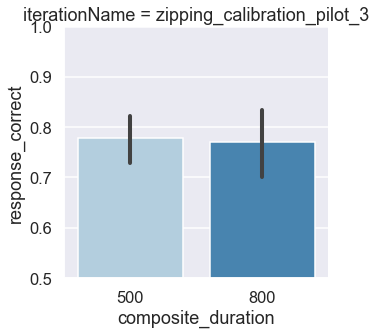

In [31]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip, 
            col = 'iterationName',
              y="response_correct", 
              x="composite_duration",
              kind='bar',
              palette='Blues')

plt.ylim((0.5,1))

#               hue="gameID")
# plt.legend(bbox_to_anchor=(1.0,1))

Very direct comparison between these two versions is a little tricky- I slightly changed the sizes/ alignment of things when I moved to the mask version.

- People do very well in the version without masks, and less well with masks.
- In general, longer composite exposures make the task easier.
- 50ms version without masks is suprisingly good. There is less data here so I'm a little less confident about it. But it's such a stark difference between the mask version- **why is that?**. Is active maintainance of the stimulus *helping*?
- For the mask version, it looks like we reach a plateau in accuracy at 200ms. 
  - but there's something weird going on with the 300ms version?
      - The simplest explanation seems to be that there are **more participants not trying/ at chance** for this particular version. Looking at the ppt mean data below, there's a failry big cluster at chance for 300ms.

##### Some notes about these versions
For 50 to 300 ms composite durations, we always display the potential parts 500ms after composite onset.
This means the gap between composite and parts gets *smaller*.
For 500 and 800ms composite durations, we increase this onset duration to 1000ms.
This means there are 500ms and 200ms gap between the composite and parts for these versions.

There seems to be something going on around 300ms. 
This *could* also be something to do with the smaller mask presentation time.
I'd be surprised- in all of [50,100,200,300] the time between the start of the composite and the start of the parts is the same. Why would a smaller gap make a difference?
Could the rapid changes be offputting in some way? Might the rapid presentation of the mask be interfering with the memory of the composite in a way that wouldn't happen if the mask was more stable? Maybe, I think this would come out in the wash with more data.

#### What is the distribution of performance?

<Figure size 720x432 with 0 Axes>

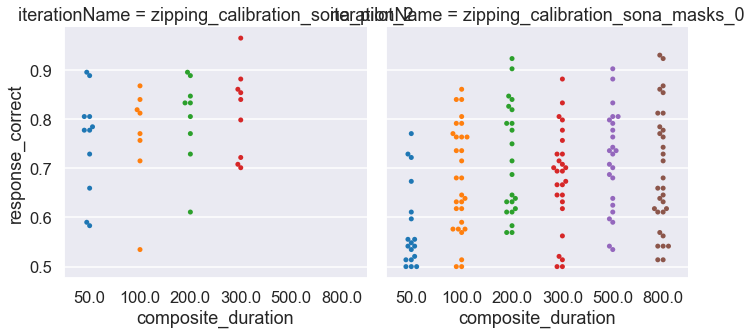

In [481]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip_ppt_mean, 
            col = 'iterationName',
              y="response_correct", 
              x="composite_duration",
              kind='swarm')
#               hue="gameID")
# plt.legend(bbox_to_anchor=(1.0,1))

It looks like a lot of people are at change for the 50ms composite exposure. There are a handgul of people around chance for other exposures.



### What about RT?

<Figure size 720x432 with 0 Axes>

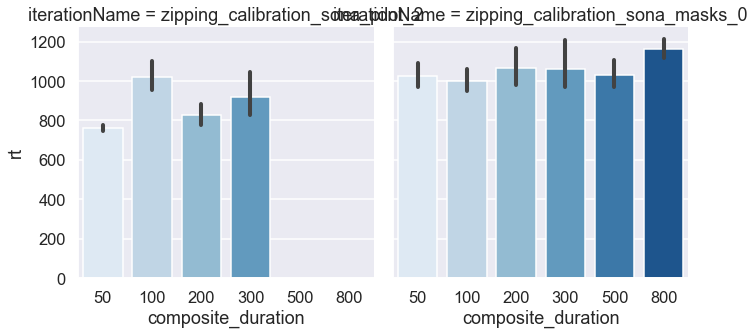

In [482]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip, 
            col = 'iterationName',
              y="rt", 
              x="composite_duration",
              kind='bar',
              palette='Blues')
#               hue="gameID")
# plt.legend(bbox_to_anchor=(1.0,1))

- RTs are greater for masked trials.
- RTs gnerally increase with higher composite duration. Is this because it's *harder* for participants, or because the pacing of the task makes responses seem more urgent in the lower durations?
    - There is something strange going on with 200ms version this time, but the large error bar and raw (mean) values below make me think this is driven by a few participants. It looks like a steady increase otherwise

<Figure size 720x432 with 0 Axes>

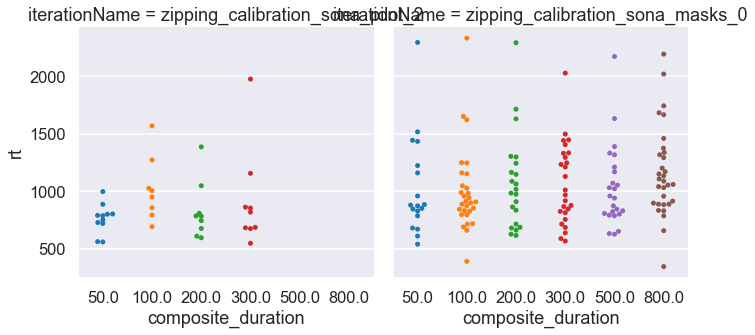

In [483]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip_ppt_mean, 
            col = 'iterationName',
              y="rt", 
              x="composite_duration",
              kind='swarm')
#               hue="gameID")
# plt.legend(bbox_to_anchor=(1.0,1))

In [484]:
df_zip_block_mean

gameID  block_number           rt  \
0    0122-4e1d44f5-f989-4e97-b611-a733135b8bd6           0.0   995.352083   
1    0122-4e1d44f5-f989-4e97-b611-a733135b8bd6           1.0   830.777083   
2    0122-4e1d44f5-f989-4e97-b611-a733135b8bd6           2.0   734.156250   
3    0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e           0.0  3810.875000   
4    0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e           1.0  1753.518750   
..                                         ...           ...          ...   
556  9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c           1.0   741.197917   
557  9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c           2.0   644.439583   
558  9996-d73fe18f-c74f-486c-bcb8-8d7305140221           0.0   914.208333   
559  9996-d73fe18f-c74f-486c-bcb8-8d7305140221           1.0   903.402083   
560  9996-d73fe18f-c74f-486c-bcb8-8d7305140221           2.0   820.291667   

     response_correct  practice  composite_duration  gap_duration  \
0            0.812500       0.0               300.0         200.0   
1            0.791667       0.0               300.0         200.0   
2            0.791667       0.0               300.0         200.0   
3            0.708333       0.0               100.0         400.0   
4            0.750000       0.0               100.0         400.0   
..                ...       ...                 ...           ...   
556          0.666667       0.0               500.0         500.0   
557          0.812500       0.0               500.0         500.0   
558          0.541667       0.0                50.0         450.0   
559          0.583333       0.0                50.0         450.0   
560          0.541667       0.0                50.0         450.0   

     chunk_duration  compatible_trial  stimVersionInd  trial_num  trial_index  \
0            1000.0               0.0             9.0       24.5         33.5   
1            1000.0               0.0             9.0       72.5         83.5   
2            1000.0               0.0             9.0      120.5        133.5   
3            1000.0               0.0            10.0       24.5         34.5   
4            1000.0               0.0            10.0       72.5         84.5   
..              ...               ...             ...        ...          ...   
556          1000.0               0.0            11.0       72.5         84.5   
557          1000.0               0.0            11.0      120.5        134.5   
558          1000.0               0.0            10.0       24.5         34.5   
559          1000.0               0.0            10.0       72.5         84.5   
560          1000.0               0.0            10.0      120.5        134.5   

      time_elapsed  common  trial_bin                     iterationName  
0    310942.833333     0.5   2.041667  zipping_calibration_sona_pilot_2  
1    586272.312500     0.5   6.041667  zipping_calibration_sona_pilot_2  
2    810939.145833     0.5  10.041667  zipping_calibration_sona_pilot_2  
3    320055.354167     0.5   2.041667  zipping_calibration_sona_masks_0  
4    635723.312500     0.5   6.041667  zipping_calibration_sona_masks_0  
..             ...     ...        ...                               ...  
556  600354.062500     0.5   6.041667  zipping_calibration_sona_masks_0  
557  833586.083333     0.5  10.041667  zipping_calibration_sona_masks_0  
558  312886.020833     0.5   2.041667  zipping_calibration_sona_masks_0  
559  682385.895833     0.5   6.041667  zipping_calibration_sona_masks_0  
560  903897.395833     0.5  10.041667  zipping_calibration_sona_masks_0  

[561 rows x 16 columns]

### What about the effect of common/ rare that we're looking for?

What do masks do? 
They seem to *reduce* the gap between rare and common stims. This was the opposite of what I was hoping for by introducing them.



#### Across the whole experiment

(0.5, 1.0)

<Figure size 720x432 with 0 Axes>

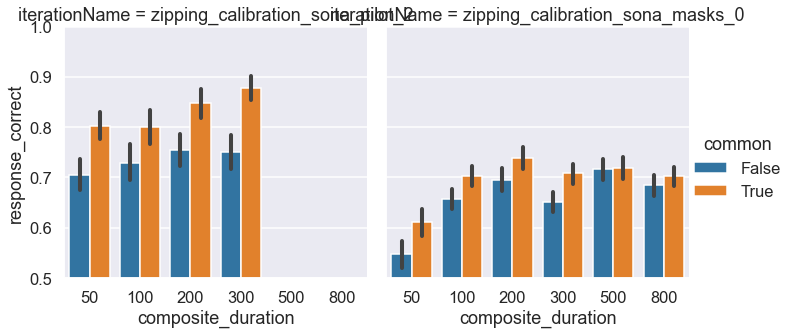

In [486]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip, 
            col = 'iterationName',
              y="response_correct", 
              x="composite_duration",
              hue="common",
              kind='bar')

plt.ylim((0.5,1))

<Figure size 720x432 with 0 Axes>

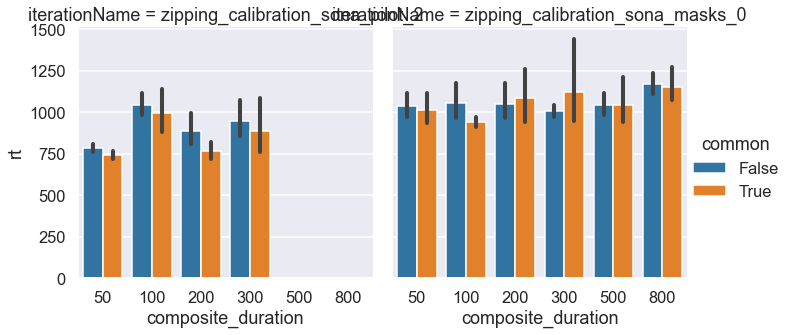

In [426]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip, 
            col = 'iterationName',
              y="rt", 
              x="composite_duration",
              hue="common",
              kind='bar')

#### Just in the final block

<Figure size 720x432 with 0 Axes>

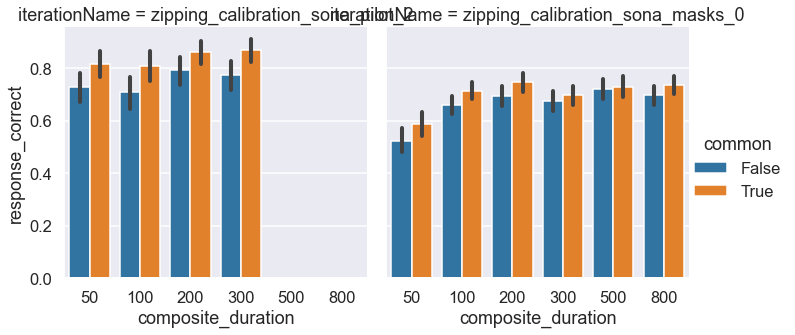

In [427]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip[df_zip.block_number == 2], 
            col = 'iterationName',
              y="response_correct", 
              x="composite_duration",
              hue="common",
              kind='bar')

<Figure size 720x432 with 0 Axes>

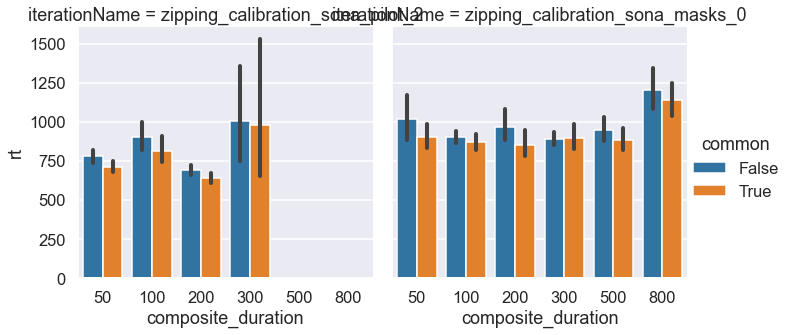

In [428]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip[df_zip.block_number == 2], 
            col = 'iterationName',
              y="rt", 
              x="composite_duration",
              hue="common",
              kind='bar')

## What affects the difference in accuracy and RT between conditions?

#### Create dataframes with differences between rare and common, and means by ppt

In [492]:
def common_diff(df):
    '''
    Returns difference between rare and common conditions for response correct and rt
    '''
    diffs = df[df.common==True][['response_correct','rt']].iloc[0] - df[df.common==False][['response_correct','rt']].iloc[0] 
    
    
    diffs = diffs.rename({'response_correct':'diff_response_correct',
                                'rt':'diff_rt'})
    
    return diffs

In [493]:
# start with means
ppt_common_diffs = df_zip_common_mean.groupby('gameID')[['response_correct','rt','common']]

In [494]:
# find differences between common conditions
ppt_common_diffs = ppt_common_diffs.apply(common_diff)

In [495]:
# merge in useful data from original dataframe
ppt_common_diffs = ppt_common_diffs.merge(df_zip.groupby('gameID').first()\
                    [['iterationName','composite_duration']], how='left', on='gameID')

In [496]:
# merge mean columns from original mean dataframe
ppt_common_diffs = ppt_common_diffs.merge(df_zip_ppt_mean.groupby('gameID').first()\
                    [['rt','response_correct']], how='left', on='gameID')

# and rename mean columns
ppt_common_diffs = ppt_common_diffs.rename(columns=
                 {'response_correct':'mean_response_correct',
                                'rt':'mean_rt'})

In [497]:
ppt_common_diffs

diff_response_correct      diff_rt  \
gameID                                                                          
0122-4e1d44f5-f989-4e97-b611-a733135b8bd6              -0.013889    -7.326389   
0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e               0.111111 -1028.456944   
0257-7b120a19-b701-4756-a263-838c2e23e90f               0.069444  -168.730556   
0288-3e2777b2-da84-4d28-a11d-f796eb5b0680              -0.055556    -8.530556   
0304-f84e750f-063a-4aa2-a237-652a38724edc               0.027778   -98.248611   
...                                                          ...          ...   
9847-84adb0e8-d0e7-4373-854c-67329cacd383               0.138889  -122.997222   
9851-54087919-9584-4c47-b2c1-ff14c52edfeb               0.111111   -74.269444   
9875-5883ced1-807a-414e-a8e2-9f88476c5c81               0.000000   351.788889   
9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c              -0.194444   -57.452778   
9996-d73fe18f-c74f-486c-bcb8-8d7305140221              -0.138889   -35.668056   

                                                              iterationName  \
gameID                                                                        
0122-4e1d44f5-f989-4e97-b611-a733135b8bd6  zipping_calibration_sona_pilot_2   
0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e  zipping_calibration_sona_masks_0   
0257-7b120a19-b701-4756-a263-838c2e23e90f  zipping_calibration_sona_masks_0   
0288-3e2777b2-da84-4d28-a11d-f796eb5b0680  zipping_calibration_sona_masks_0   
0304-f84e750f-063a-4aa2-a237-652a38724edc  zipping_calibration_sona_masks_0   
...                                                                     ...   
9847-84adb0e8-d0e7-4373-854c-67329cacd383  zipping_calibration_sona_masks_0   
9851-54087919-9584-4c47-b2c1-ff14c52edfeb  zipping_calibration_sona_pilot_2   
9875-5883ced1-807a-414e-a8e2-9f88476c5c81  zipping_calibration_sona_masks_0   
9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c  zipping_calibration_sona_masks_0   
9996-d73fe18f-c74f-486c-bcb8-8d7305140221  zipping_calibration_sona_masks_0   

                                           composite_duration      mean_rt  \
gameID                                                                       
0122-4e1d44f5-f989-4e97-b611-a733135b8bd6                 300   853.428472   
0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e                 100  2329.471528   
0257-7b120a19-b701-4756-a263-838c2e23e90f                 800  1291.416667   
0288-3e2777b2-da84-4d28-a11d-f796eb5b0680                  50   609.988889   
0304-f84e750f-063a-4aa2-a237-652a38724edc                 100   826.514583   
...                                                       ...          ...   
9847-84adb0e8-d0e7-4373-854c-67329cacd383                 500   939.912500   
9851-54087919-9584-4c47-b2c1-ff14c52edfeb                 200   609.562500   
9875-5883ced1-807a-414e-a8e2-9f88476c5c81                 500  1630.406944   
9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c                 500   786.529167   
9996-d73fe18f-c74f-486c-bcb8-8d7305140221                  50   879.300694   

                                           mean_response_correct  
gameID                                                            
0122-4e1d44f5-f989-4e97-b611-a733135b8bd6               0.798611  
0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e               0.680556  
0257-7b120a19-b701-4756-a263-838c2e23e90f               0.784722  
0288-3e2777b2-da84-4d28-a11d-f796eb5b0680               0.555556  
0304-f84e750f-063a-4aa2-a237-652a38724edc               0.791667  
...                                                          ...  
9847-84adb0e8-d0e7-4373-854c-67329cacd383               0.708333  
9851-54087919-9584-4c47-b2c1-ff14c52edfeb               0.847222  
9875-5883ced1-807a-414e-a8e2-9f88476c5c81               0.638889  
9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c               0.736111  
9996-d73fe18f-c74f-486c-bcb8-8d7305140221               0.555556  

[187 rows x 6 columns]

Do more accurate people also have the biggest difference between common and rare?

<Figure size 720x432 with 0 Axes>

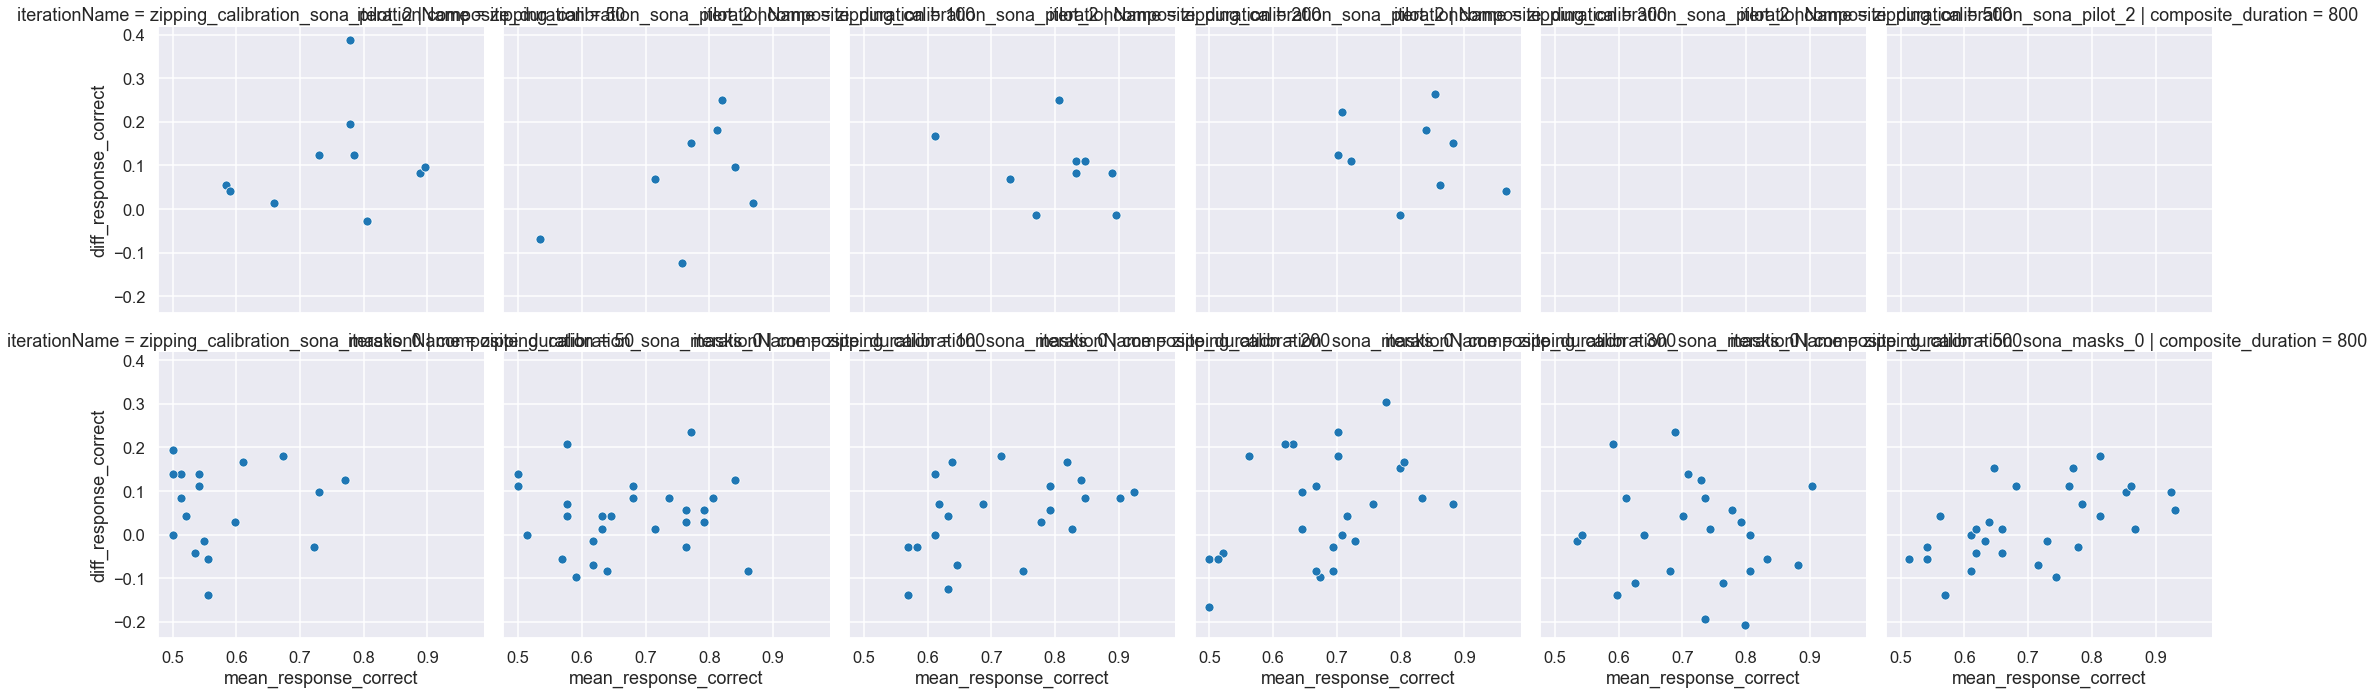

In [498]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data=ppt_common_diffs, 
             row = 'iterationName',
             col = 'composite_duration',
              y="diff_response_correct",
              x="mean_response_correct",
              kind='scatter')

<AxesSubplot:xlabel='mean_response_correct', ylabel='diff_response_correct'>

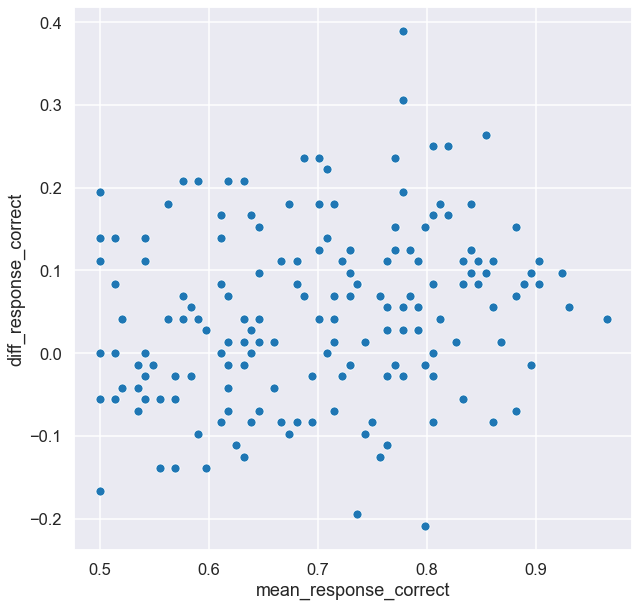

In [501]:
fig = plt.figure(figsize=(10,10))

sns.scatterplot(data=ppt_common_diffs, 
              y="diff_response_correct",
              x="mean_response_correct",)

Do faster people have the biggest difference between common and rare?

<Figure size 720x432 with 0 Axes>

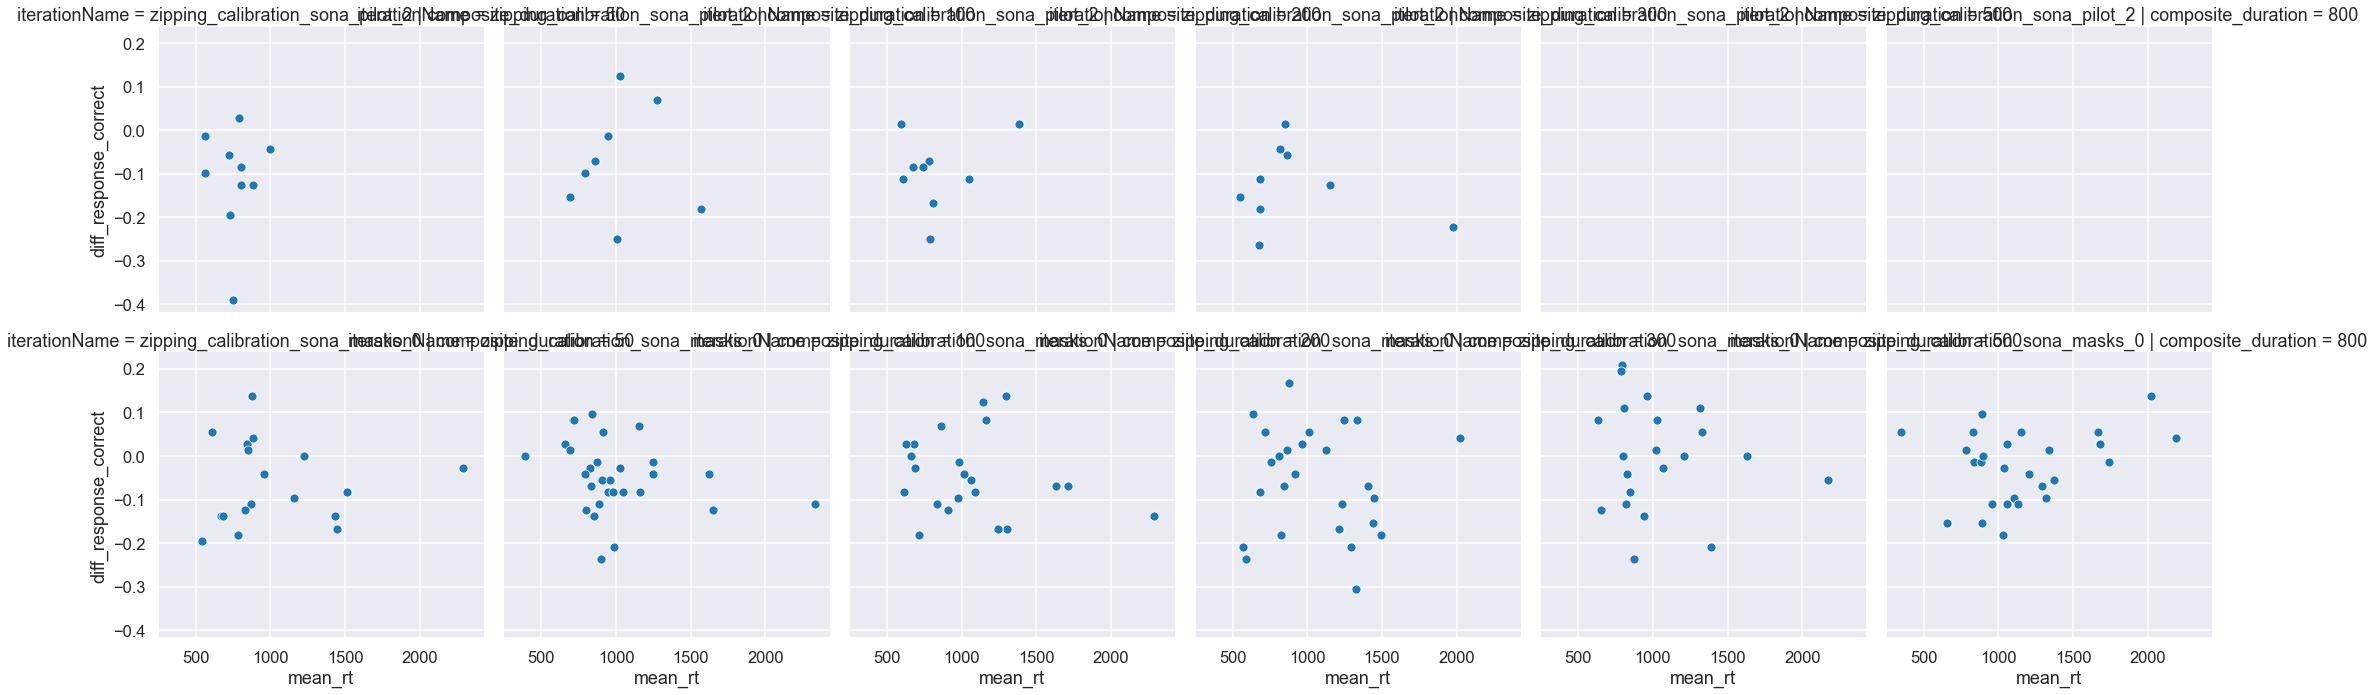

In [436]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data=ppt_common_diffs, 
             row = 'iterationName',
             col = 'composite_duration',
              y="diff_response_correct",
              x="mean_rt",
              kind='scatter')

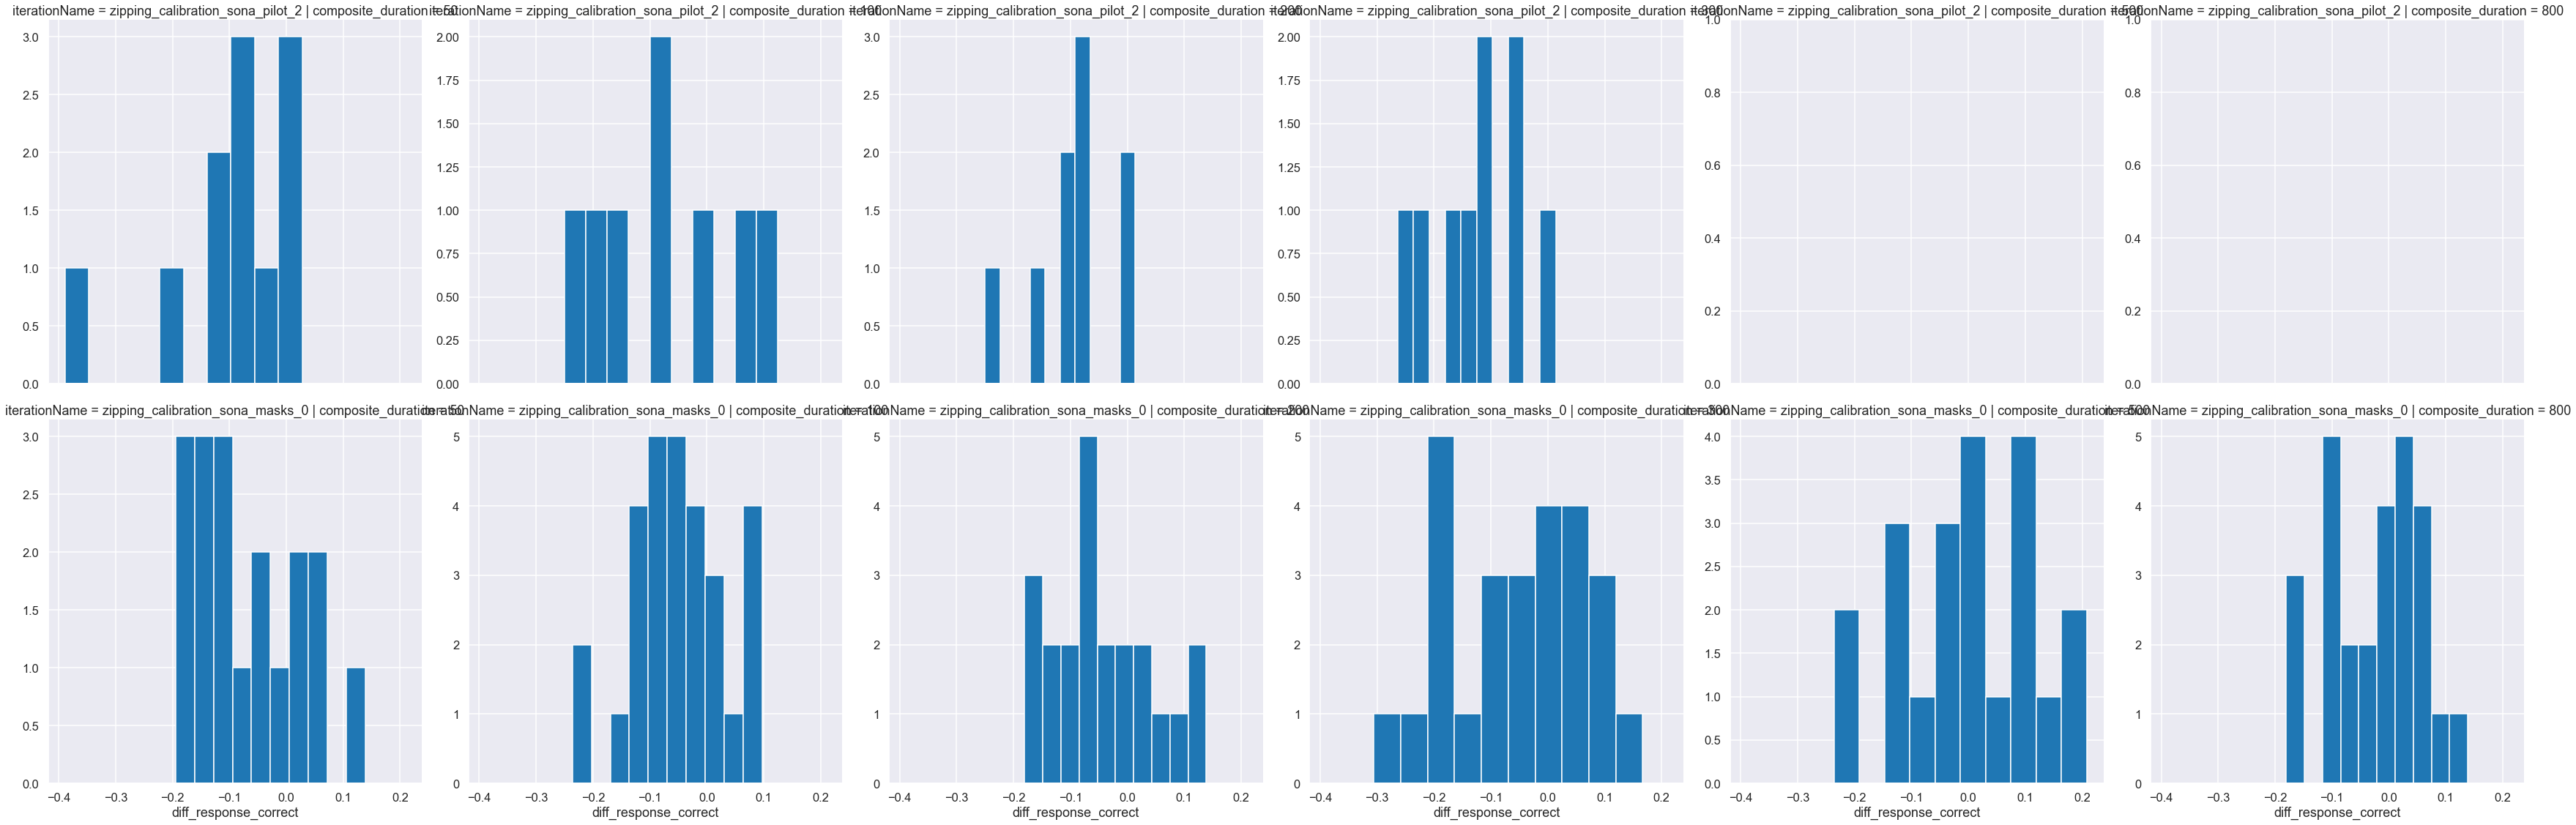

In [490]:
g = sns.FacetGrid(ppt_common_diffs, 
                  row = "iterationName",
                  col = "composite_duration", 
                  height=8,
                  sharey= False)

g.map_dataframe(plt.hist,
                  x="diff_response_correct",
                
#                   x="block_number",
#                   hue="gameID",
#                   palette="bright",
                  )

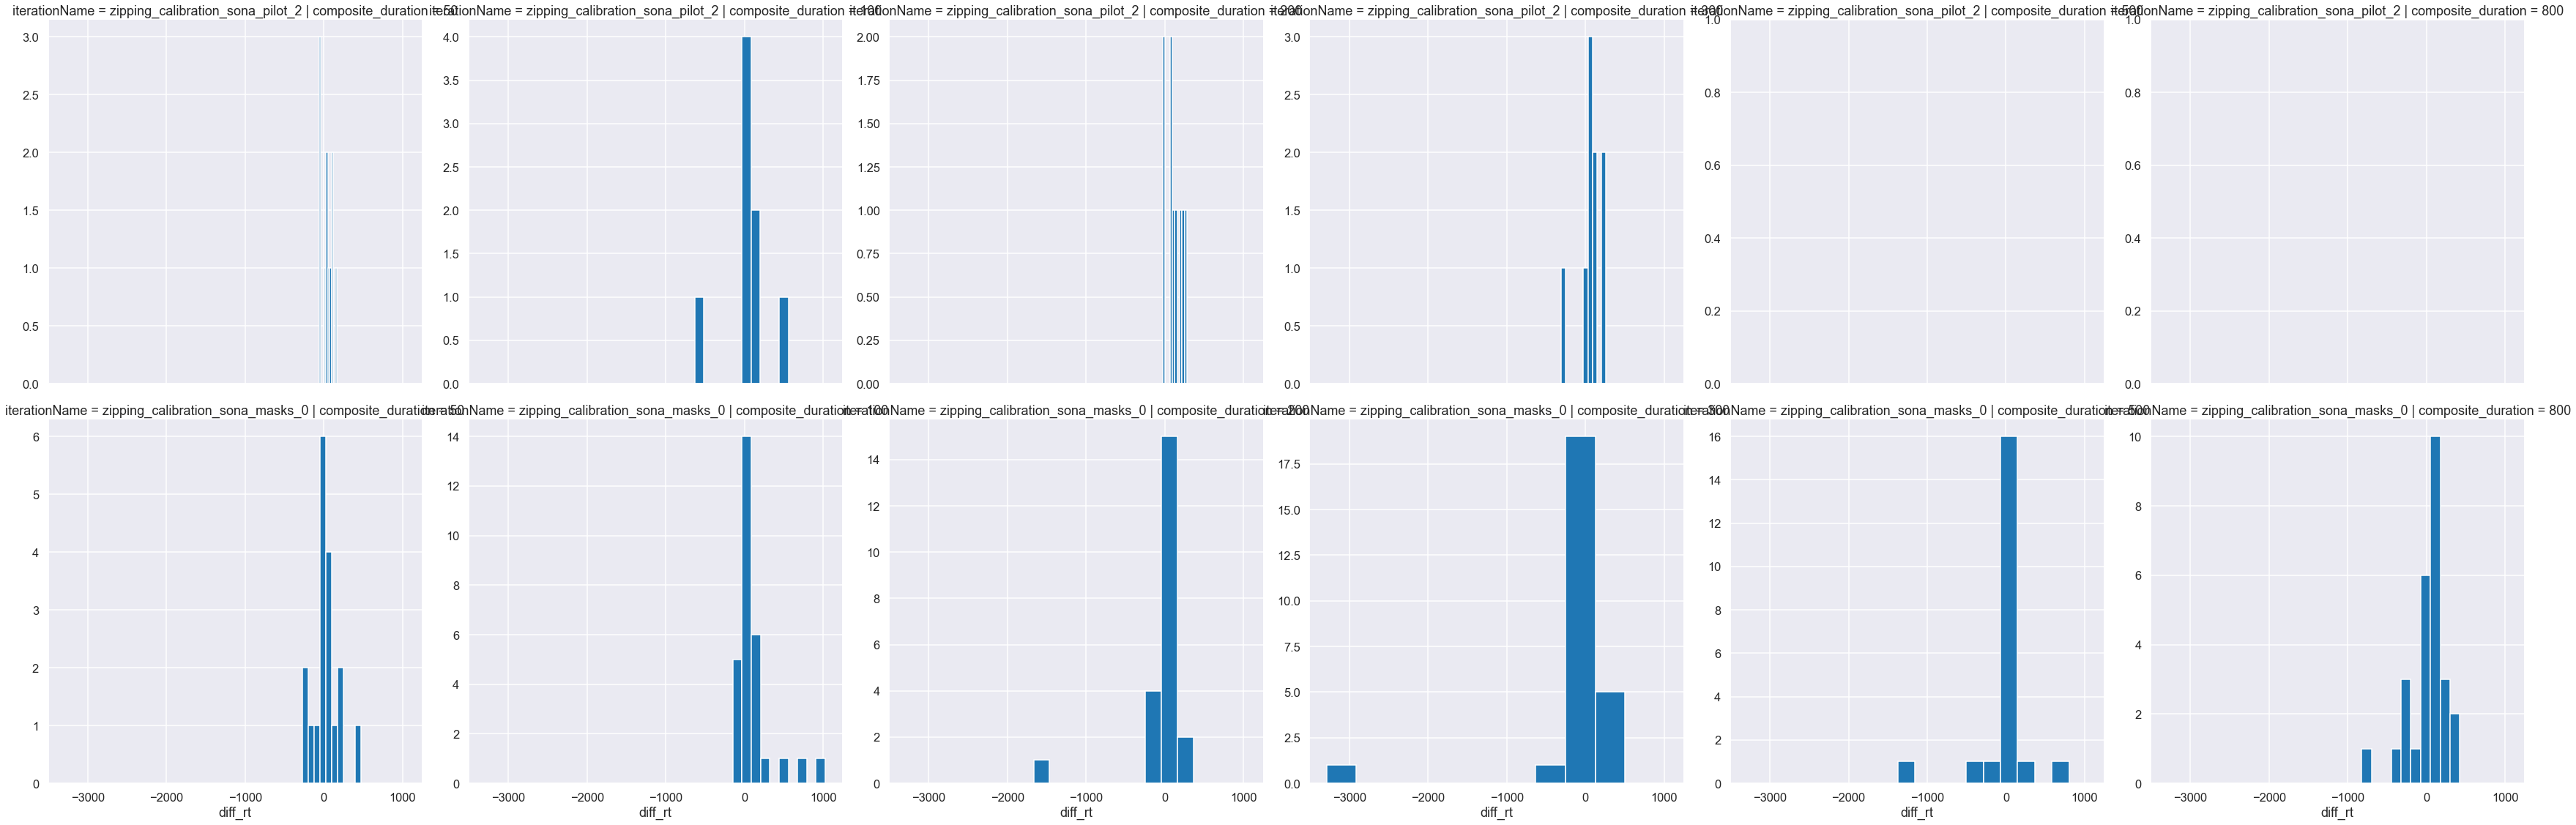

In [491]:
g = sns.FacetGrid(ppt_common_diffs, 
                  row = "iterationName",
                  col = "composite_duration", 
                  height=8,
                  sharey= False)

g.map_dataframe(plt.hist,
                  x="diff_rt",
                
#                   x="block_number",
#                   hue="gameID",
#                   palette="bright",
                  )

#### Create dataframes with differences between rare and common for each block

In [437]:
ppt_block_common_diffs = df_zip_block_common_mean.groupby(['gameID','block_number'])\
                    [['common','response_correct','rt']]

In [438]:
ppt_block_common_diffs = ppt_block_common_diffs.apply(lambda x: common_diff(x)).reset_index()\
                        .merge(df_zip.groupby('gameID').first()\
                            [['iterationName','composite_duration']], how='left', on='gameID')


In [439]:
# merge mean columns from original mean dataframe
ppt_block_common_diffs = ppt_block_common_diffs.merge(df_zip_ppt_mean.groupby('gameID').first()\
                    [['rt','response_correct']], how='left', on='gameID')

# and rename mean columns
ppt_block_common_diffs = ppt_block_common_diffs.rename(columns=
                 {'response_correct':'mean_response_correct',
                                'rt':'mean_rt'})

In [440]:
# MEANS ARE OVERALL FOR PPT

ppt_block_common_diffs

gameID  block_number  \
0    0122-4e1d44f5-f989-4e97-b611-a733135b8bd6           0.0   
1    0122-4e1d44f5-f989-4e97-b611-a733135b8bd6           1.0   
2    0122-4e1d44f5-f989-4e97-b611-a733135b8bd6           2.0   
3    0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e           0.0   
4    0168-7a5c4c65-3f9c-439f-b6e6-5510ea492e0e           1.0   
..                                         ...           ...   
535  9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c           1.0   
536  9980-ca094556-a02e-4f8a-ada0-627e66a2ac5c           2.0   
537  9996-d73fe18f-c74f-486c-bcb8-8d7305140221           0.0   
538  9996-d73fe18f-c74f-486c-bcb8-8d7305140221           1.0   
539  9996-d73fe18f-c74f-486c-bcb8-8d7305140221           2.0   

     diff_response_correct      diff_rt                     iterationName  \
0                -0.125000    30.220833  zipping_calibration_sona_pilot_2   
1                 0.083333   -11.937500  zipping_calibration_sona_pilot_2   
2                 0.083333     3.695833  zipping_calibration_sona_pilot_2   
3                -0.250000  3226.716667  zipping_calibration_sona_masks_0   
4                 0.000000  -368.437500  zipping_calibration_sona_masks_0   
..                     ...          ...                               ...   
535               0.083333    69.312500  zipping_calibration_sona_masks_0   
536               0.291667    33.237500  zipping_calibration_sona_masks_0   
537               0.083333    50.283333  zipping_calibration_sona_masks_0   
538               0.333333    45.154167  zipping_calibration_sona_masks_0   
539               0.000000    11.566667  zipping_calibration_sona_masks_0   

     composite_duration      mean_rt  mean_response_correct  
0                   300   853.428472               0.798611  
1                   300   853.428472               0.798611  
2                   300   853.428472               0.798611  
3                   100  2329.471528               0.680556  
4                   100  2329.471528               0.680556  
..                  ...          ...                    ...  
535                 500   786.529167               0.736111  
536                 500   786.529167               0.736111  
537                  50   879.300694               0.555556  
538                  50   879.300694               0.555556  
539                  50   879.300694               0.555556  

[540 rows x 8 columns]

<Figure size 720x432 with 0 Axes>

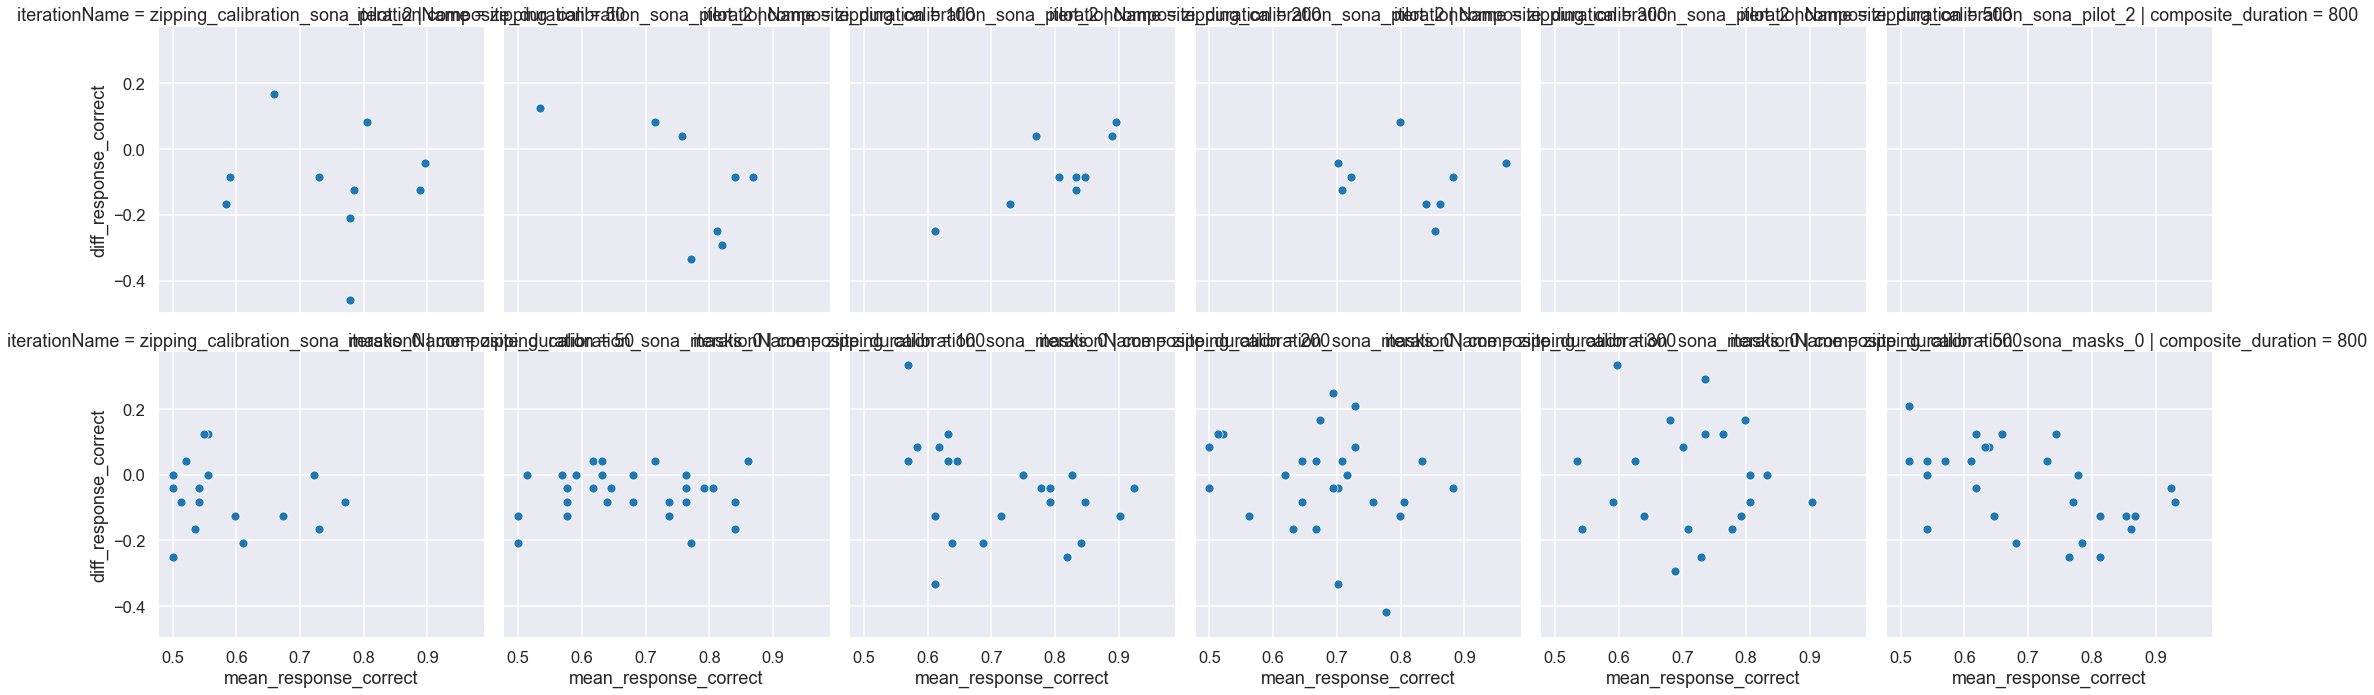

In [441]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data=ppt_block_common_diffs[ppt_block_common_diffs.block_number==2], 
             row = 'iterationName',
             col = 'composite_duration',
              y = "diff_response_correct",
              x = "mean_response_correct",
              kind='scatter')

<Figure size 720x432 with 0 Axes>

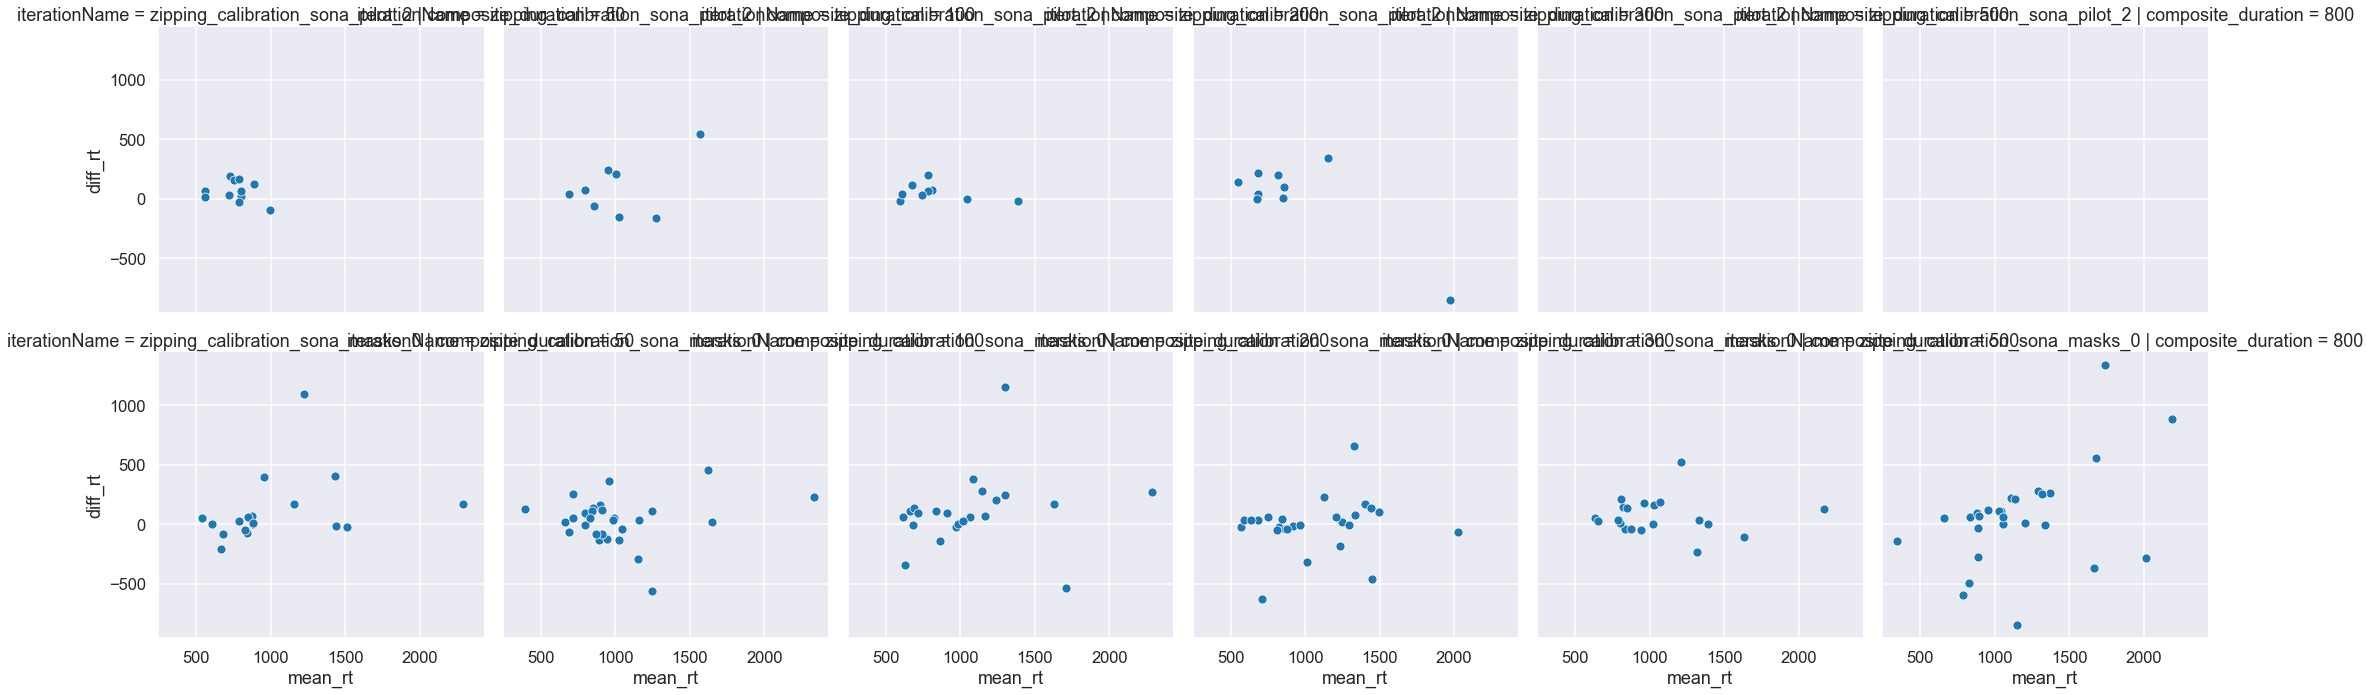

In [442]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data=ppt_block_common_diffs[ppt_block_common_diffs.block_number==2], 
             row = 'iterationName',
             col = 'composite_duration',
              y = "diff_rt",
              x = "mean_rt",
              kind='scatter')

In [443]:
### Question I want to ask?

### What is performance like across the task? Do people get better as they practice?

Not obviously...

<Figure size 720x432 with 0 Axes>

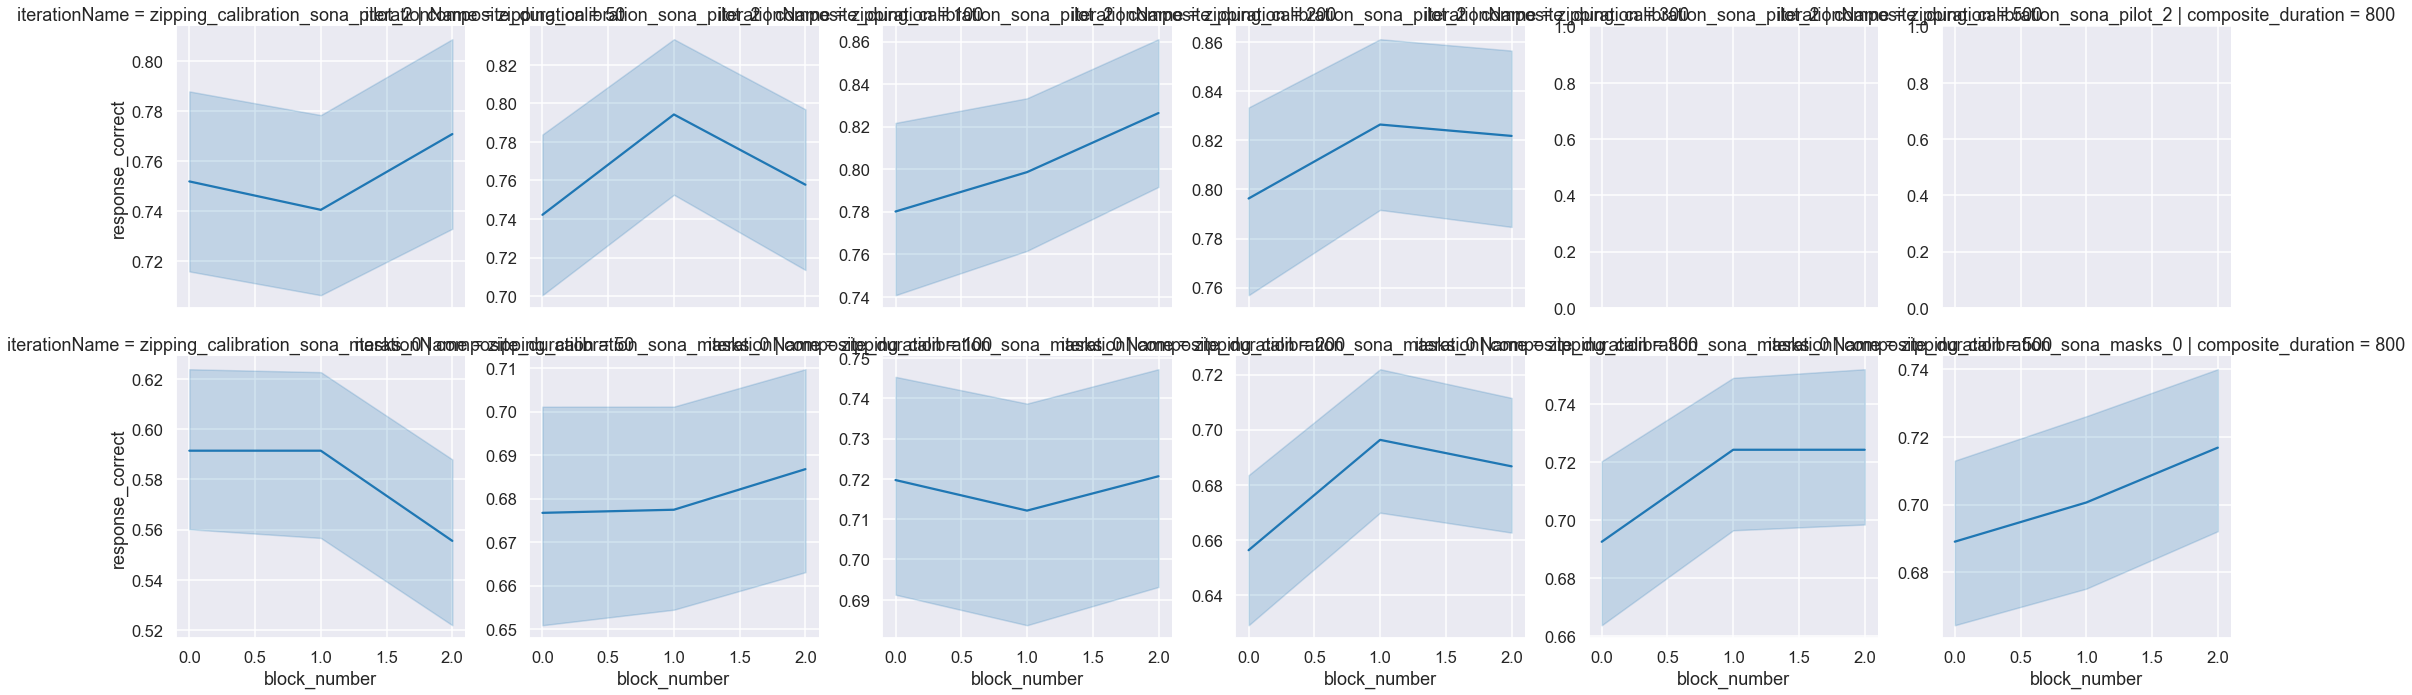

In [445]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data = df_zip, 
             row = 'iterationName',
             col = 'composite_duration',
               y = "response_correct", 
               x = "block_number",
            kind = 'line',
           facet_kws={'sharey': False, 'sharex': True}
)

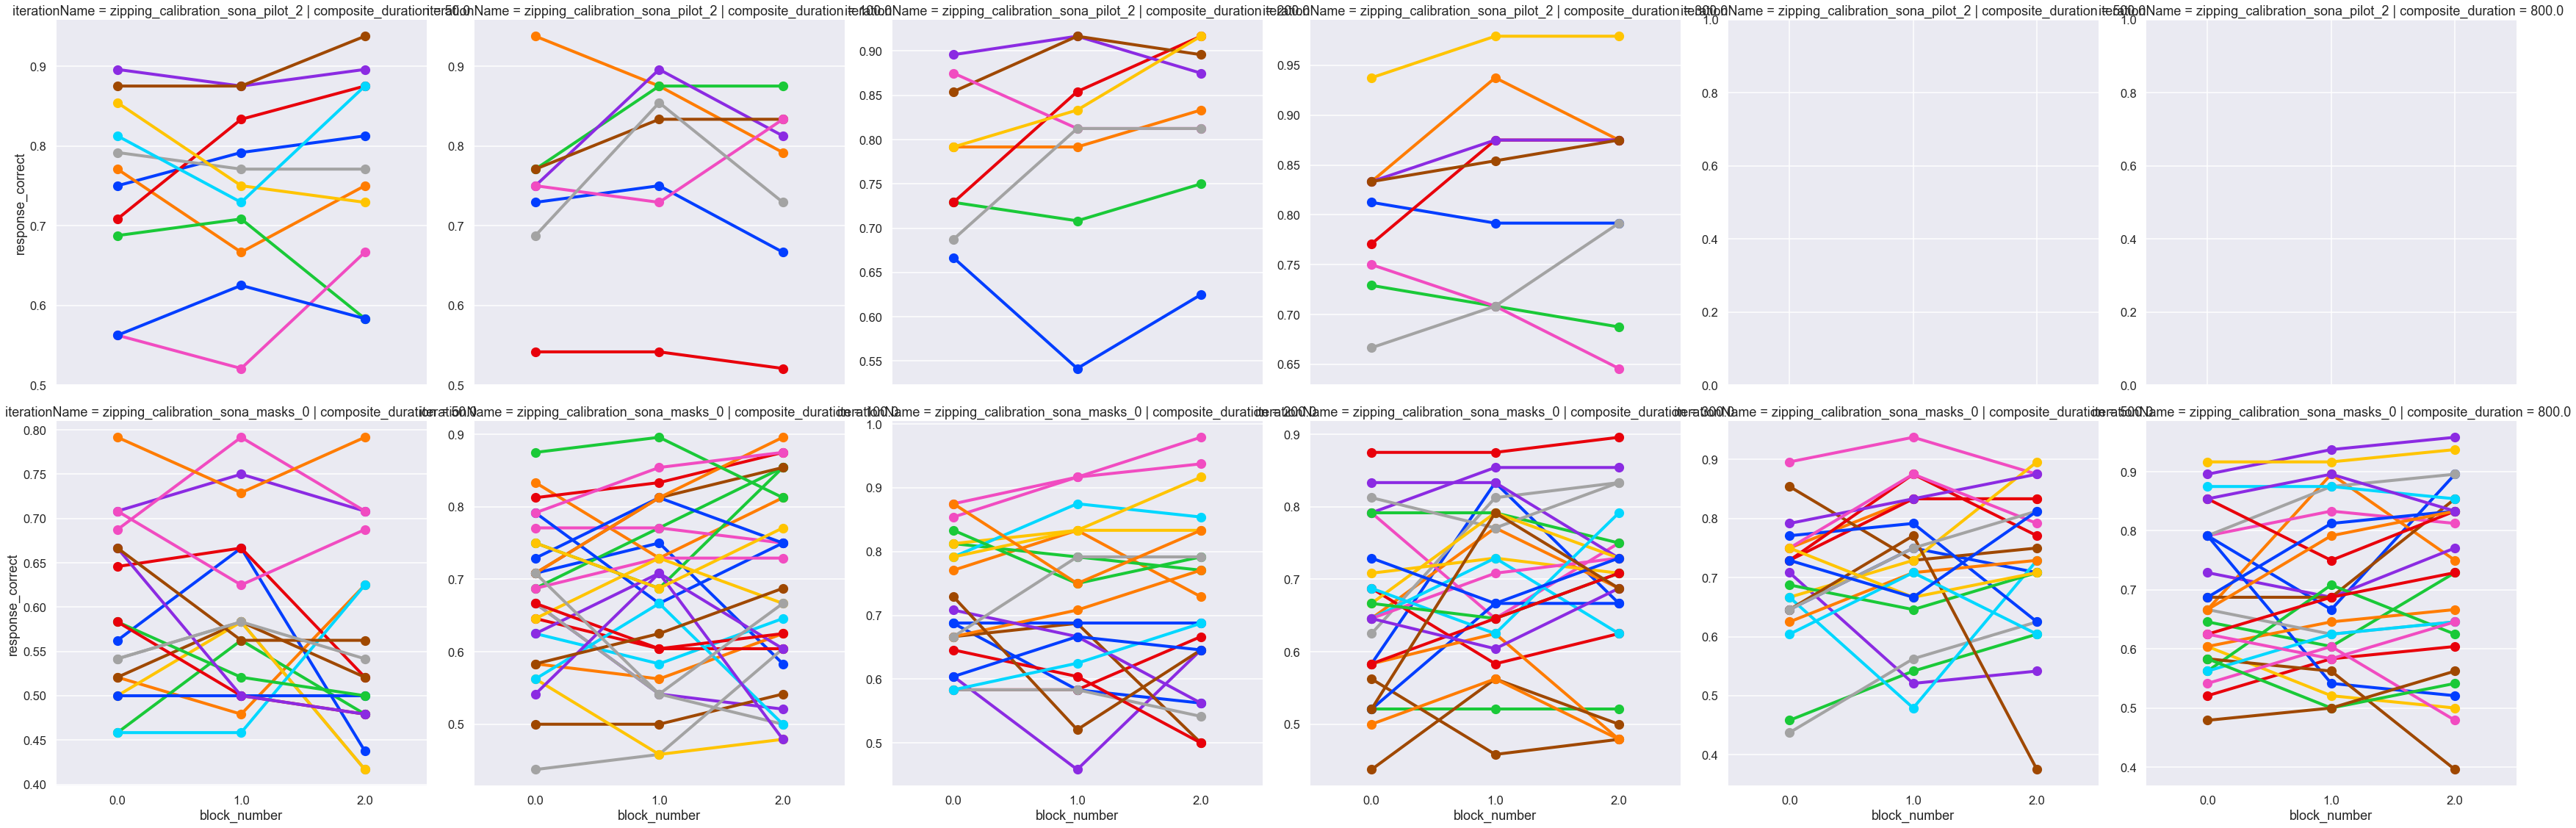

In [447]:
g = sns.FacetGrid(df_zip_block_mean, 
                  row = "iterationName",
                  col = "composite_duration", 
                  height=8,
                  sharey= False)

g.map_dataframe(sns.pointplot,
                  y="response_correct",
                  x="block_number",
                  hue="gameID",
                  palette="bright",
                  )

<Figure size 720x432 with 0 Axes>

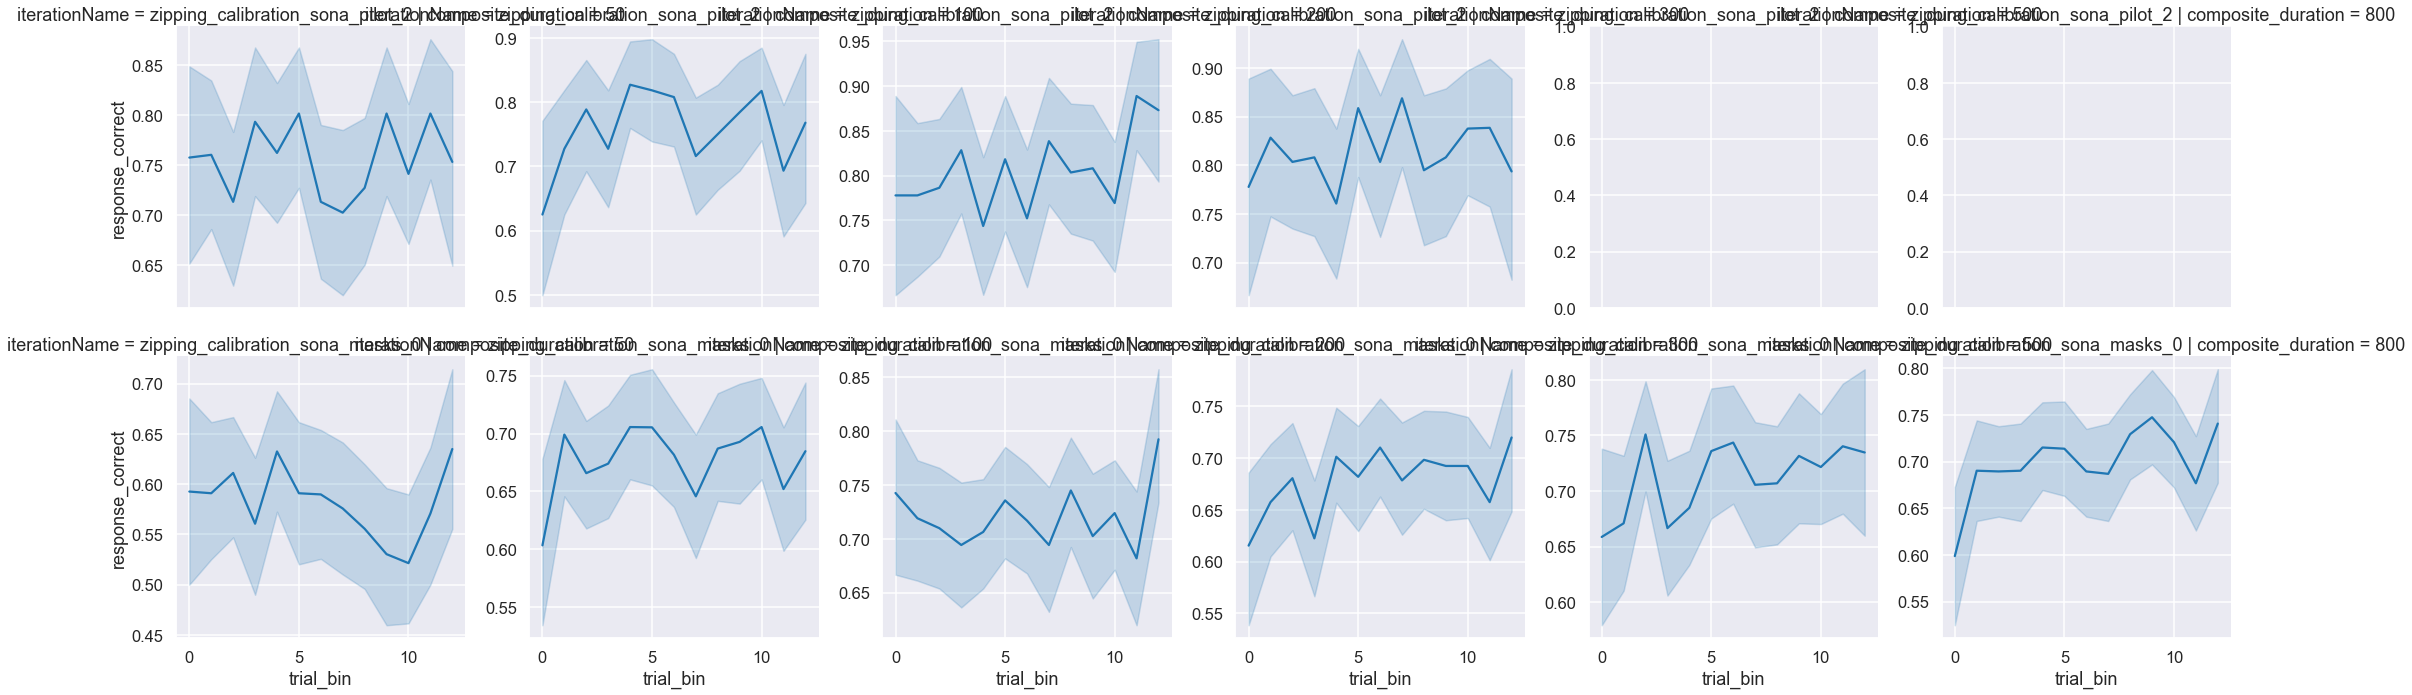

In [448]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data = df_zip, 
             row = 'iterationName',
             col = 'composite_duration',
               y = "response_correct", 
               x = "trial_bin",
            kind = 'line',
       facet_kws = {'sharey': False, 'sharex': True})

#### Well we don't really expect them to get too much better at the rare trials. But we hope they'll get better at the common ones. Do they?

Also not really...


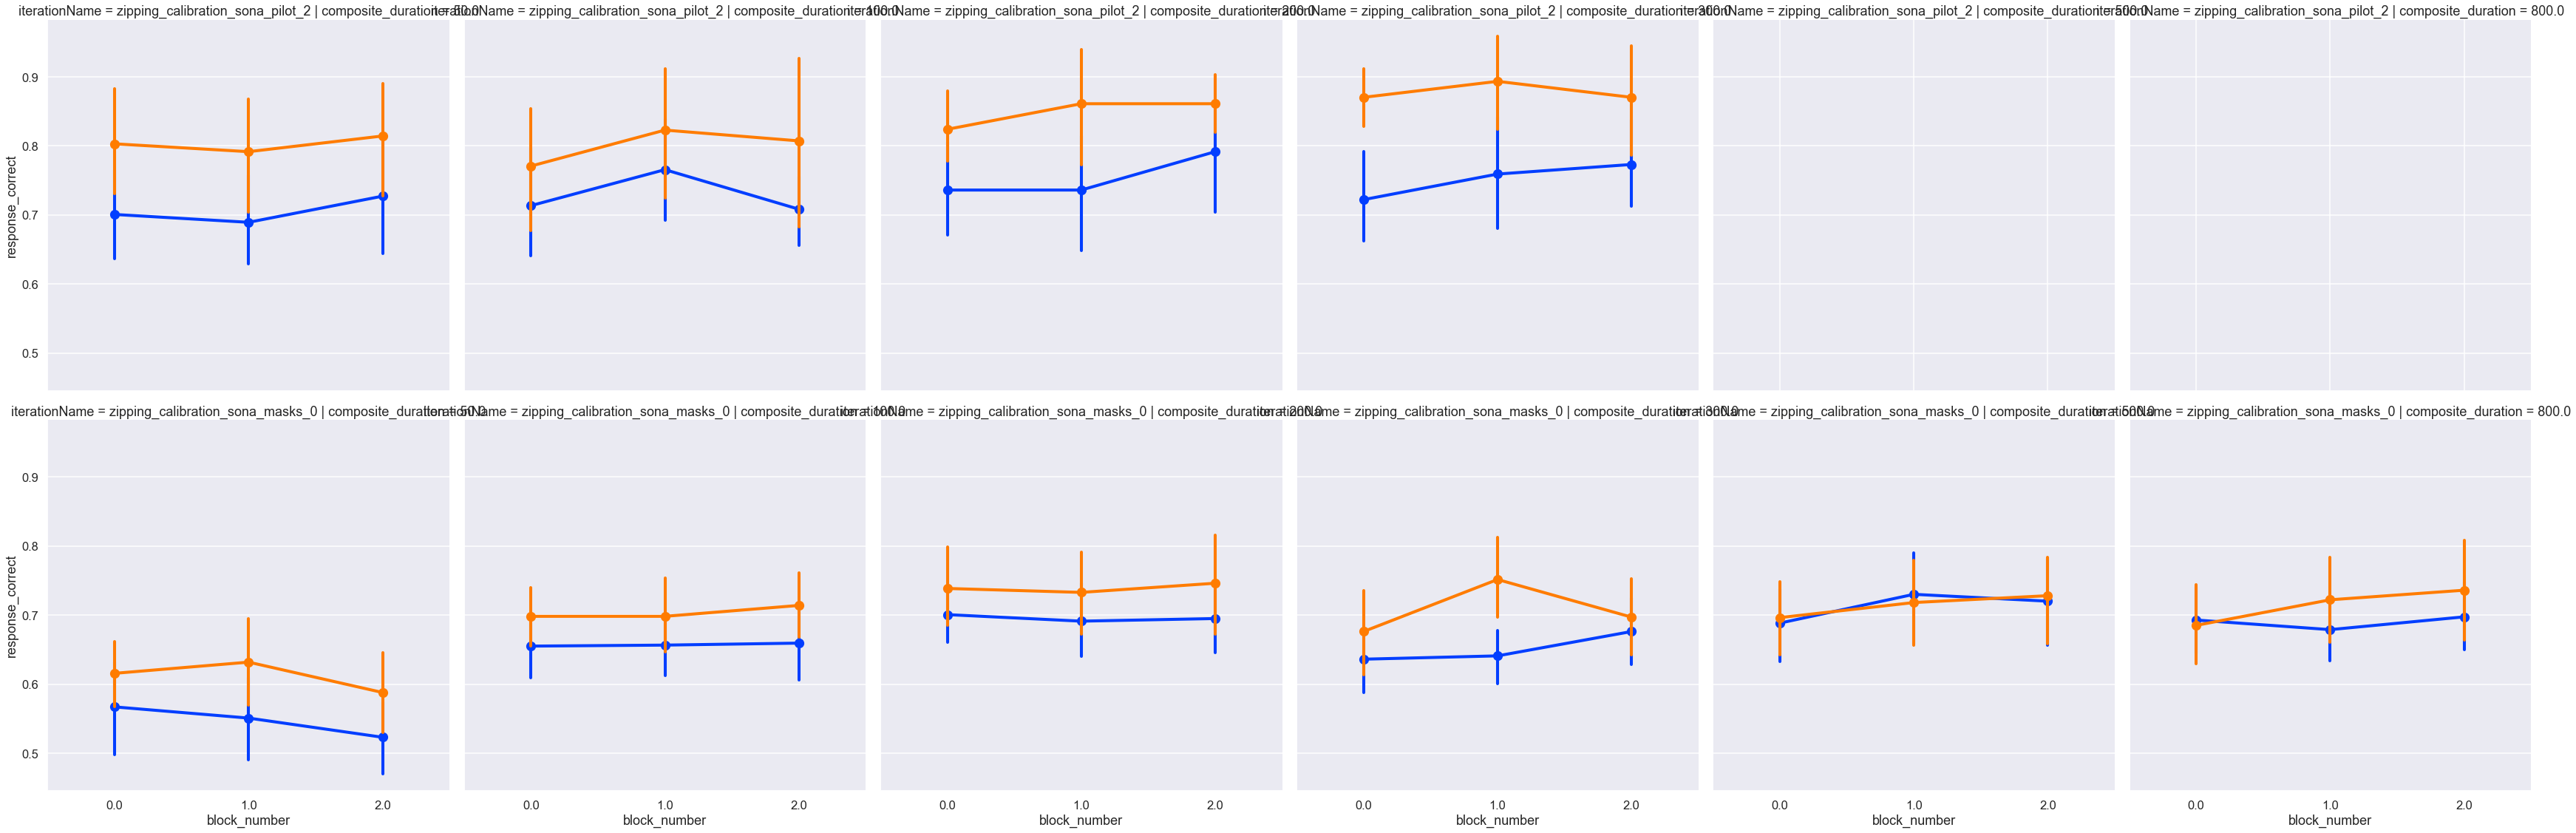

In [449]:
g = sns.FacetGrid(df_zip_block_common_mean, 
                  row = "iterationName",
                  col = "composite_duration", 
                  height=8)

g.map_dataframe(sns.pointplot,
                  y="response_correct",
                  x="block_number",
                  hue="common",
                  palette="bright",
                  facet_kws={'sharey': False, 'sharex': True})

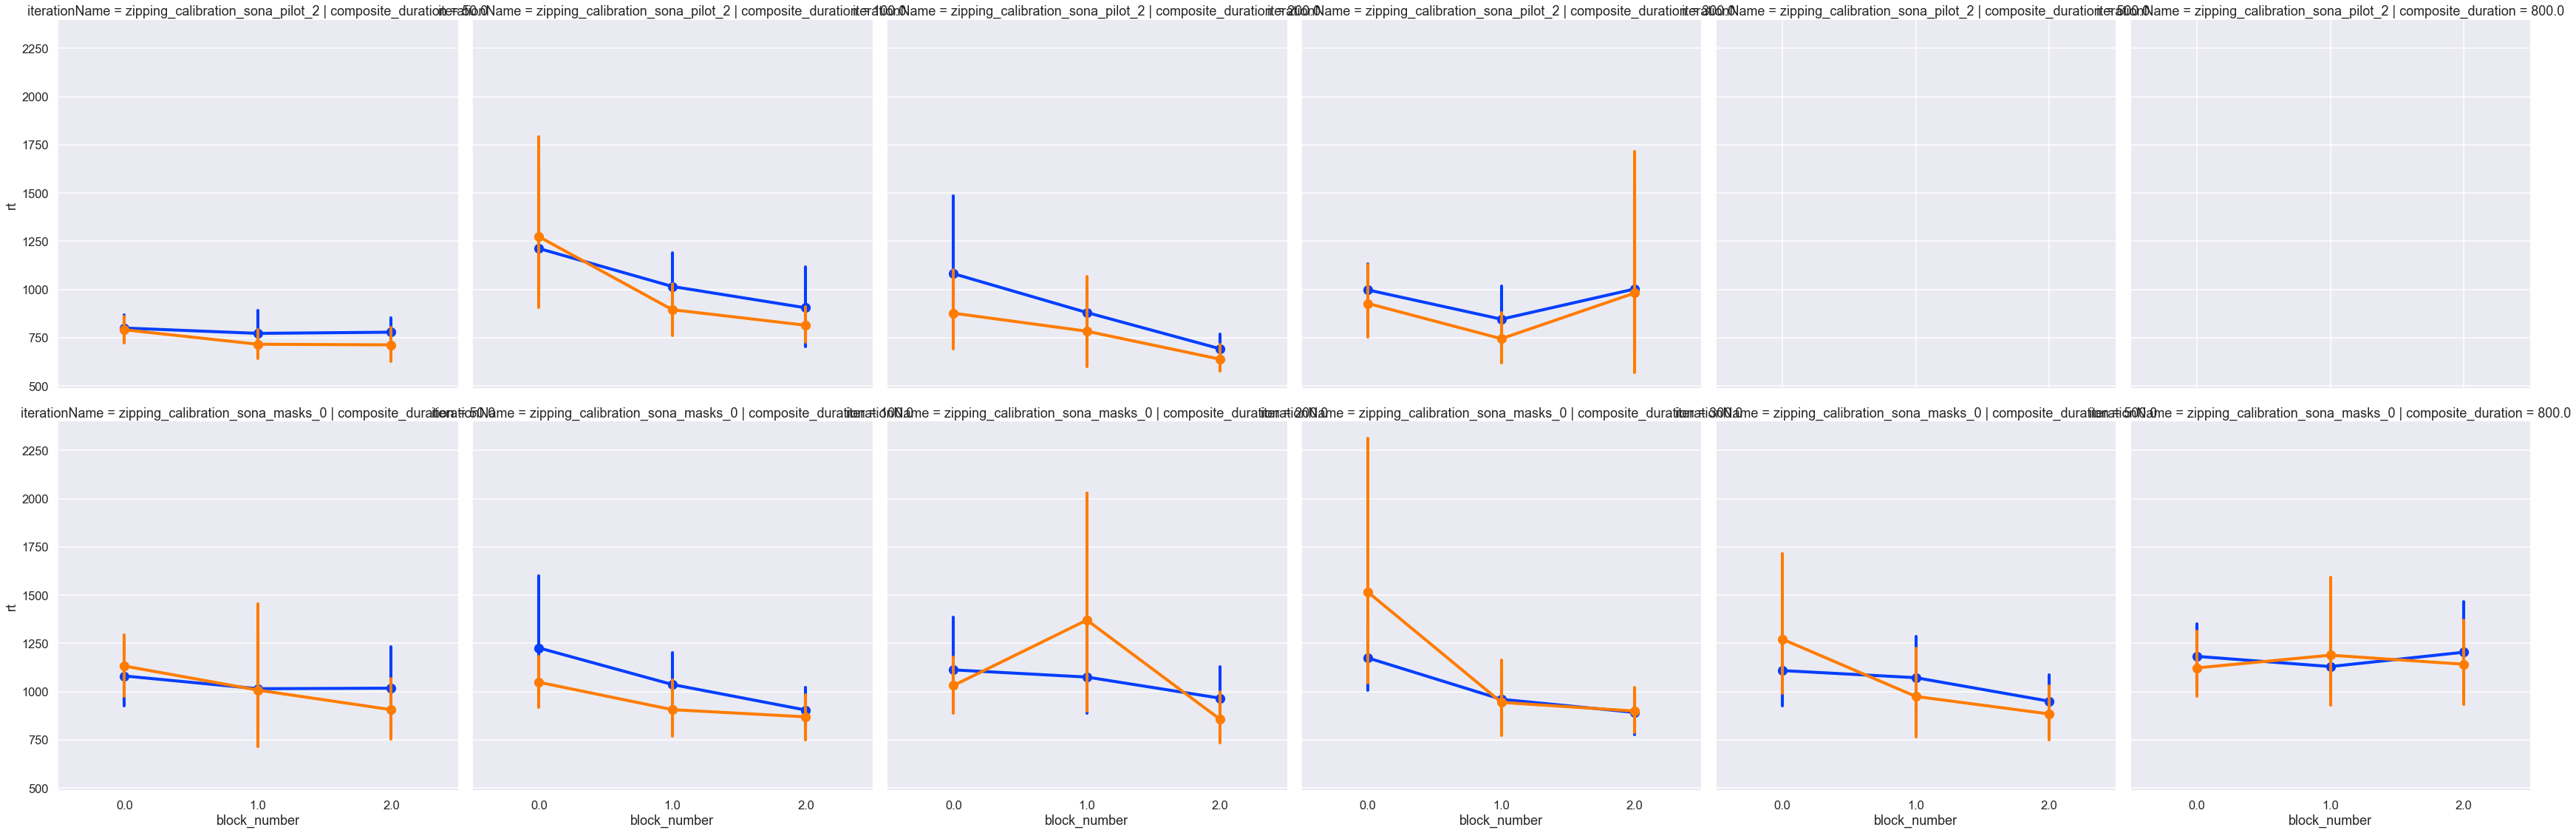

In [451]:
g = sns.FacetGrid(df_zip_block_common_mean, 
                  row = "iterationName",
                  col = "composite_duration", 
                  height=8)

g.map_dataframe(sns.pointplot,
                  y="rt",
                  x="block_number",
                  hue="common",
                  palette="bright",
                  facet_kws={'sharey': False, 'sharex': True})

#### Do masks or composite duration affect whether people improve at only the common trials?

This is the key question. We are expecting to see people start the same then diverge as they become better at the common trials...

... this doesn't seem to be happening.

<Figure size 720x432 with 0 Axes>

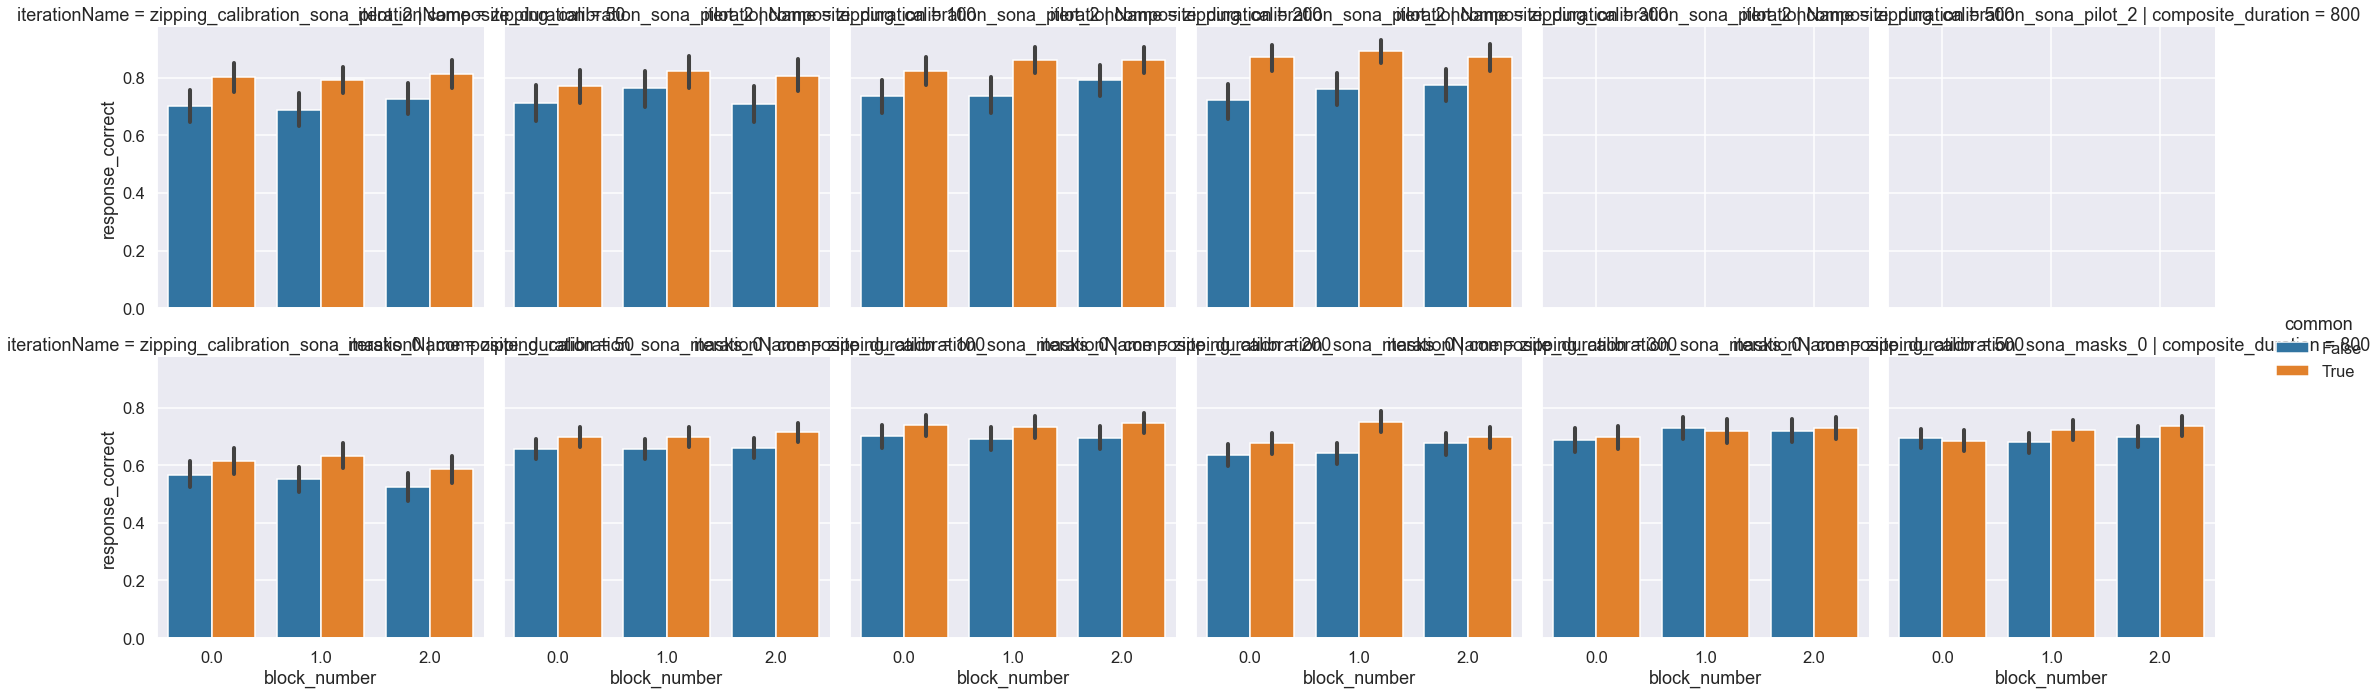

In [452]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip, 
            row = 'iterationName',
            col = 'composite_duration',
            hue = 'common',
              y="response_correct", 
              x="block_number",
              kind='bar')

In [ ]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip, 
            row = 'iterationName',
            col = 'composite_duration',
            hue = 'common',
              y="response_correct", 
              x="block_number",
              kind='bar')

It looks like participants improve at 

What about preference for tall or wide?



<Figure size 720x432 with 0 Axes>

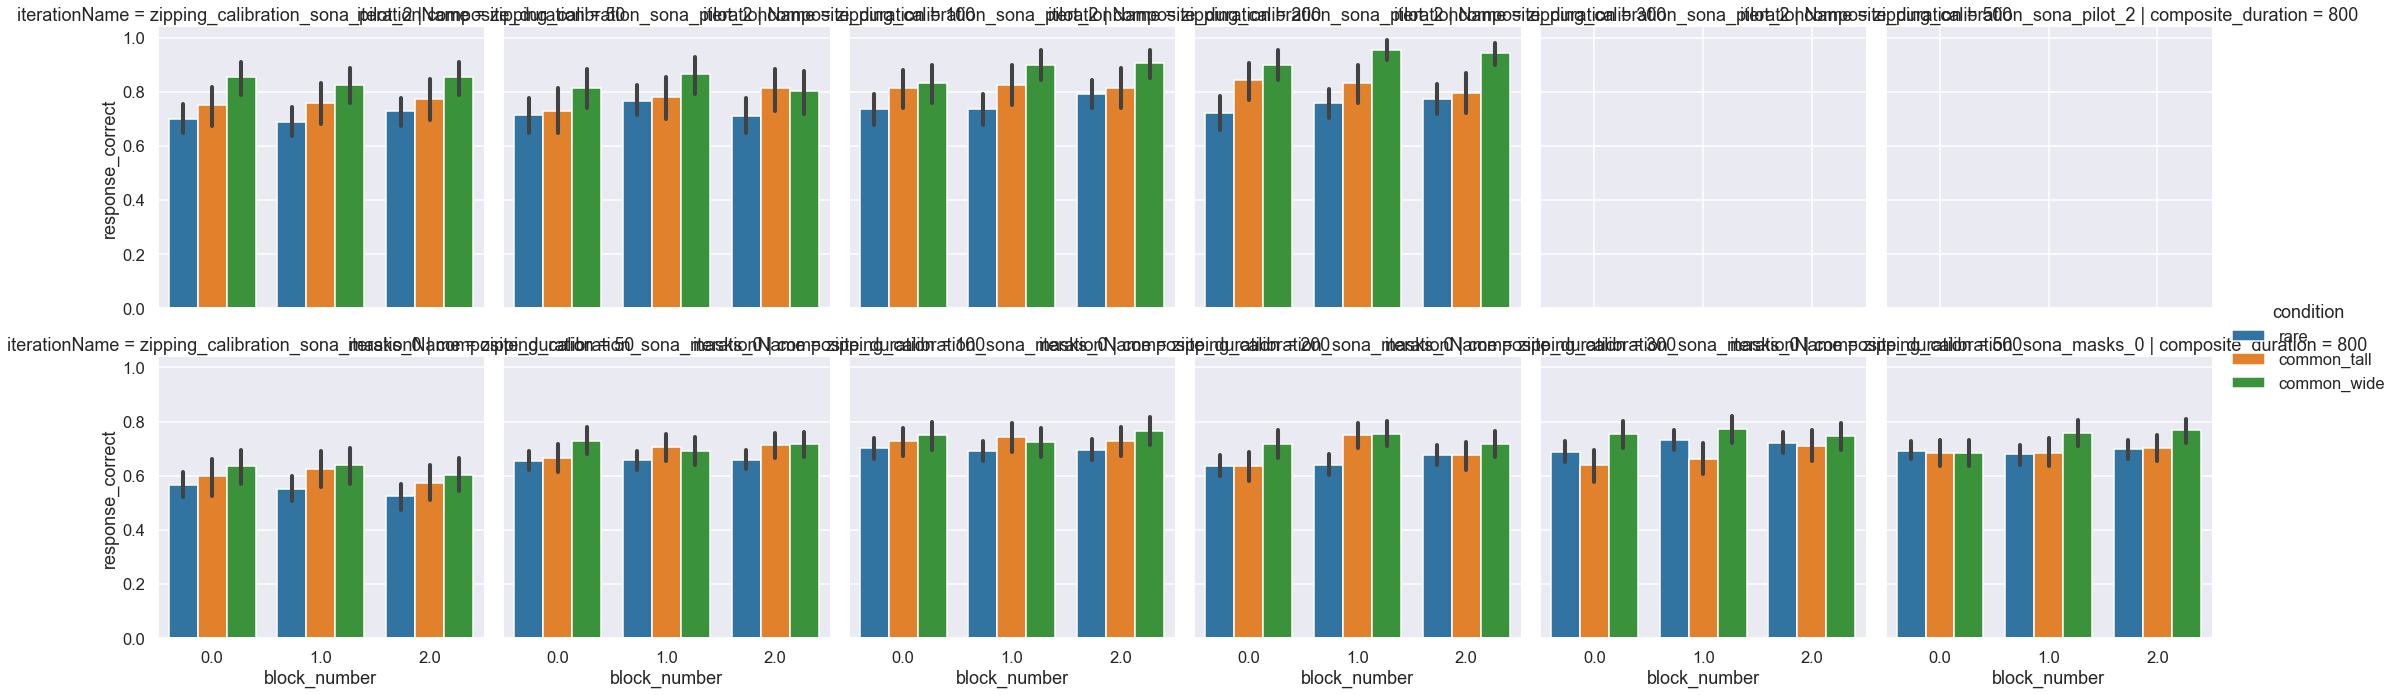

In [453]:
fig = plt.figure(figsize=(10,6))

sns.catplot(data=df_zip, 
            row = 'iterationName',
            col = 'composite_duration',
            hue = 'condition',
              y = "response_correct", 
              x = "block_number",
              kind ='bar')

In [ ]:
# maybe each participant is prioritizing tall or wide for all stimuli?

It's a little suspect that people are less good at common trials than rare trials in the *first* block. Are people just learning really quickly?

Looking at the first block only, it looks like this might be happening:

<Figure size 720x432 with 0 Axes>

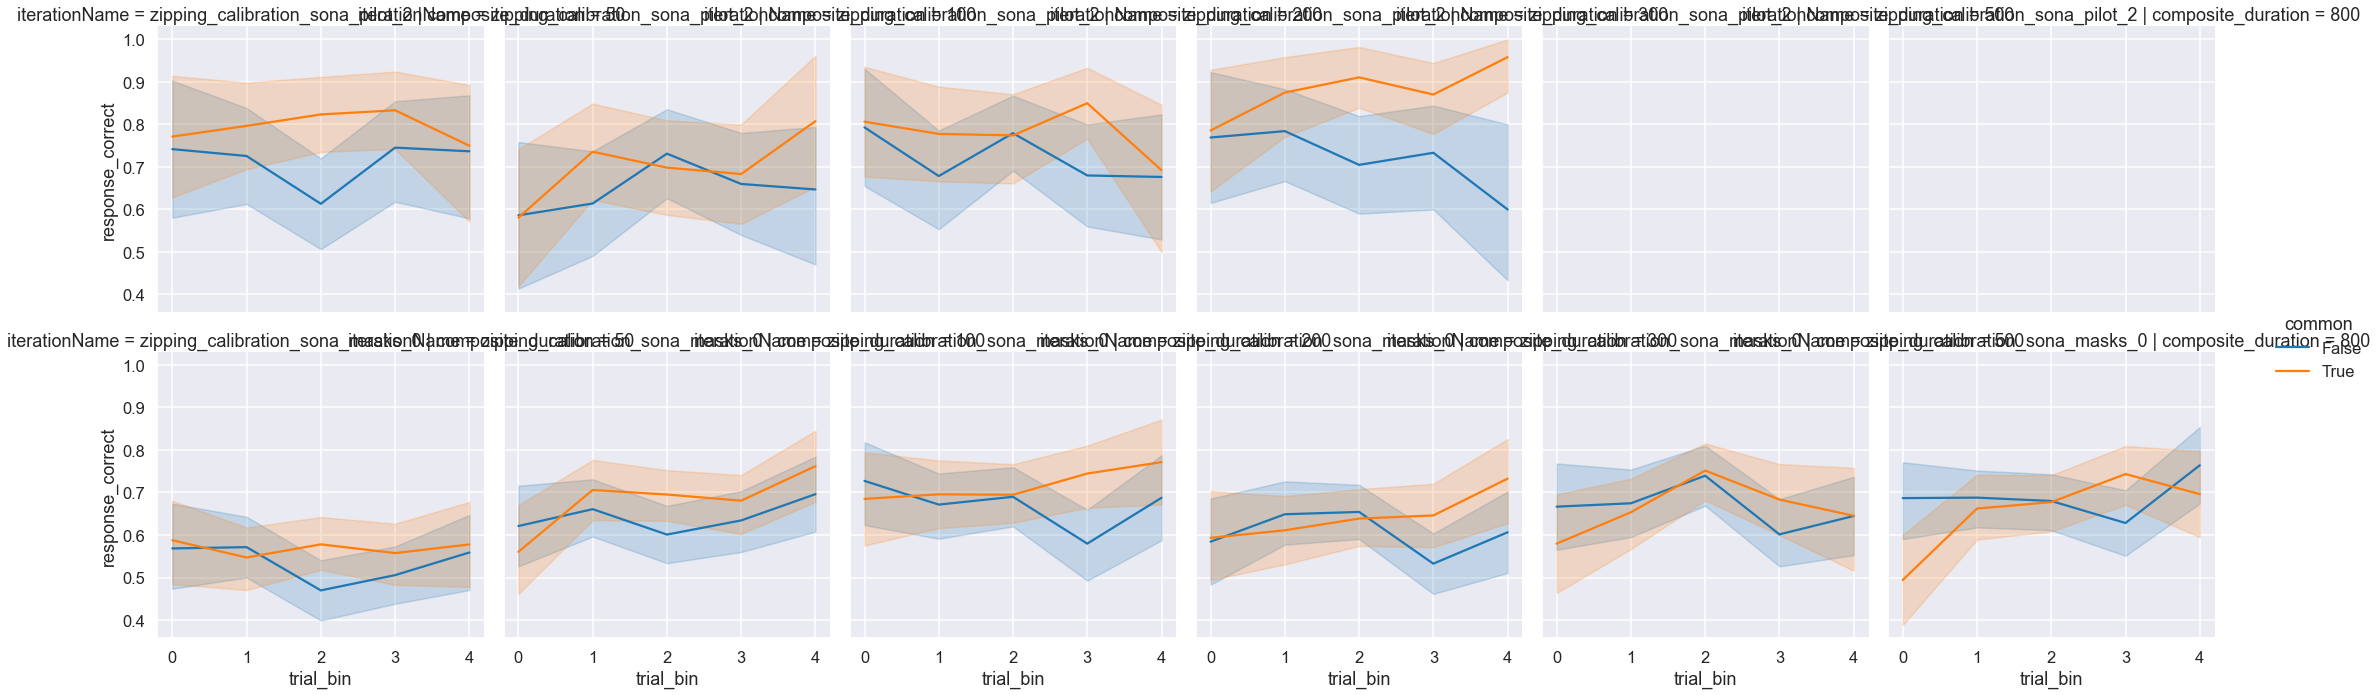

In [117]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data = df_zip[df_zip.trial_num < 48], 
             row = 'iterationName',
             col = 'composite_duration',
             hue = 'common',
               y = "response_correct", 
               x = "trial_bin",
            kind = 'line')

<Figure size 720x432 with 0 Axes>

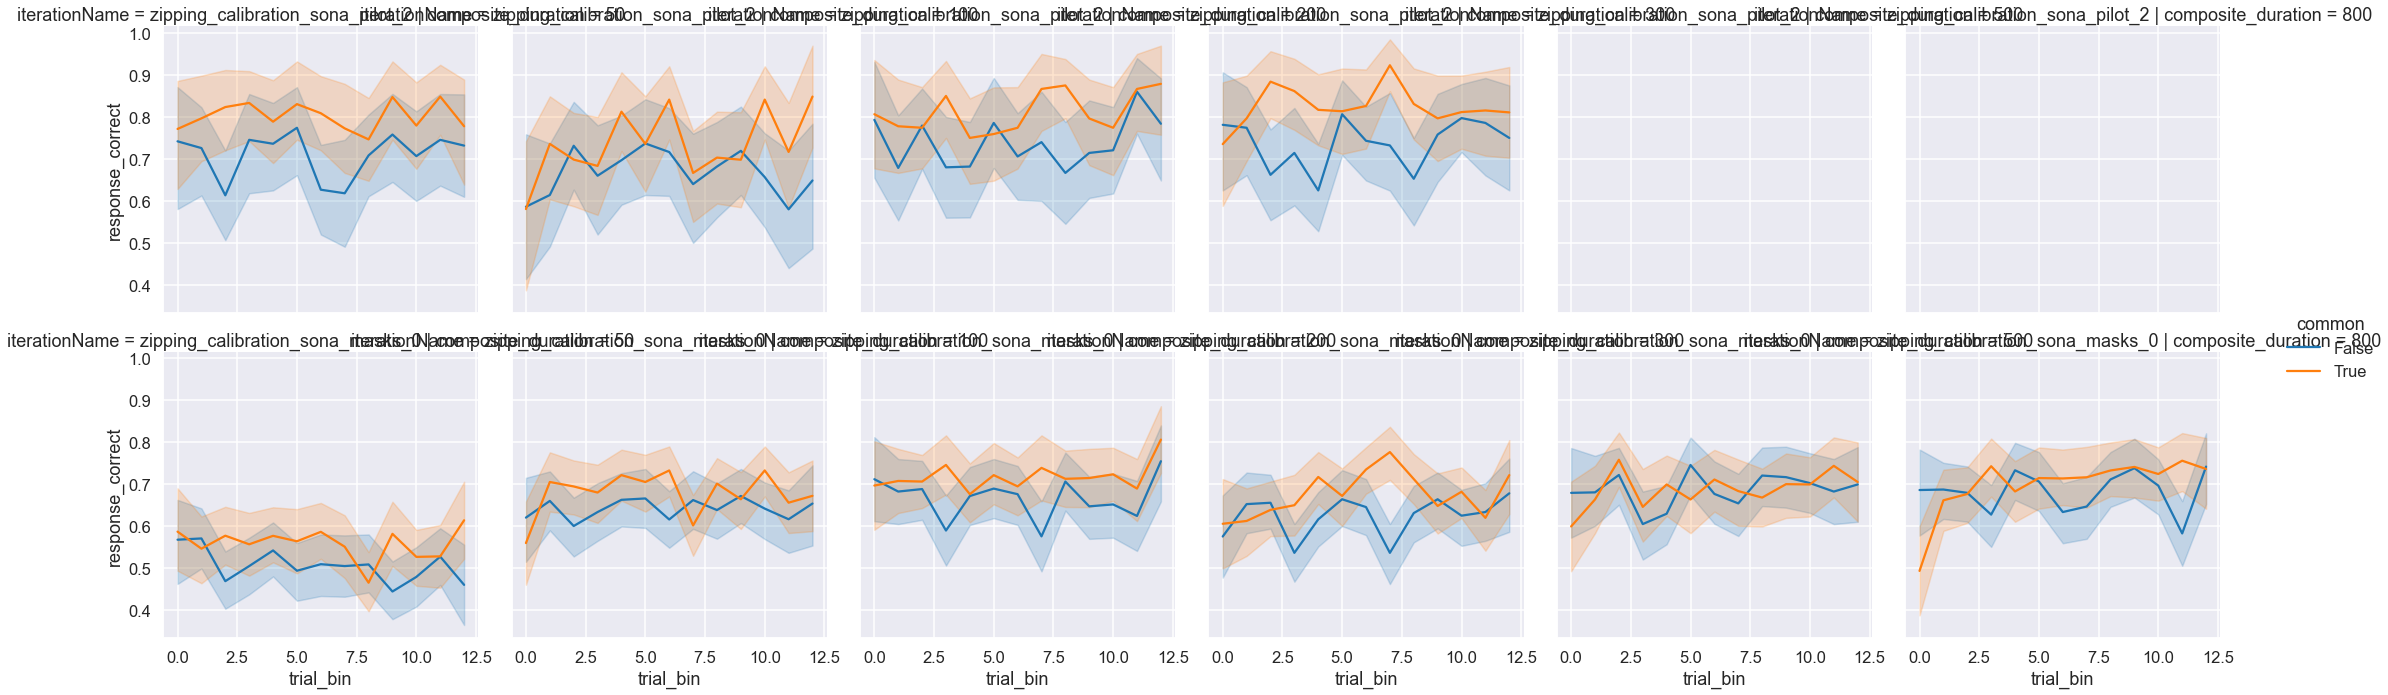

In [73]:
fig = plt.figure(figsize=(10,6))

sns.relplot(data = df_zip, 
             row = 'iterationName',
             col = 'composite_duration',
             hue = 'common',
               y = "response_correct", 
               x = "trial_bin",
            kind = 'line')

## Questions to ask

What is this manipulation doing?
It's giving participants a lot of experience with a particular shape.
In theory, in decomposing it in a particular direction.
This is passive learning.
What do we expect because of this? We expect that decomposing this stimulus in this direction will be faster. (all trials for this one are in the "compatible direction").
i.e we expect that towards the end of the experiment, common trials will be faster than rare trials.


When do we expect rare/common to play a role? Only towards the end.
How much of a difference do we expect?


#### Overall impressions of task
How hard/ easy is this task?
How hard/easy do we expect it to be, and does this match the performance we see?


#### Will this paradigm work?
Is there a large enough RT gap in any version such that we have space to ask questions about the effect of building?

If not, are there different versions of the experiment for which this gap could be larger?
Are there any trends?

Is the pattern of RTs the same across all experiments?
In which situations the largest gaps in RT occur?


Do people perform better (speed, accuracy, d') in any particular version of the experiment?


#### Stim duration- are we looking in the right range?
Does more time looking at the stimulus make you better at this task?
Is there a sweet spot?


#### Masks
What are the masks doing?
Do they make the task harder?
Do they make the task harder in specific situations?

Masks weren meant to prevent afterimages from making this task easy.
What does this mean? We're testing if people prioritize decomposition into parts they've built.



In [45]:
response_ratios = \
df_zip.groupby(['gameID','response']).apply(len).groupby('gameID').first()/\
df_zip.groupby(['gameID','response']).apply(len).groupby('gameID').last()

(array([  1.,   0.,   0.,   3.,  18., 117.,  55.,  14.,   1.,   1.]),
 array([-3.00284974, -2.47668652, -1.9505233 , -1.42436008, -0.89819686,
        -0.37203364,  0.15412959,  0.68029281,  1.20645603,  1.73261925,
         2.25878247]),
 <BarContainer object of 10 artists>)

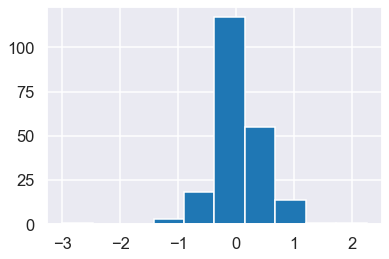

In [47]:
plt.hist(np.log(response_ratios))